In [46]:
import os
import shutil

import numpy as np
import pandas as pd
from skimage.morphology import skeletonize
from PIL import Image
import cv2
import re
import glob

from skorch import NeuralNetClassifier
from skorch.callbacks import LRScheduler, Checkpoint, EpochScoring, EarlyStopping
from skorch.dataset import Dataset
from skorch.helper import predefined_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from pathlib import Path
import tensorflow as tf
from tensorflow import keras
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import metrics

from utils_train import (checksum, determine_image_center, shadow_regions, 
                         half_skeletonize, randomly_distribute, systemic_brightening,
                        make_nonzero_dict)

In [5]:
os.chdir("/users/riya/race/classifier_experiments/CNN_train/code")

In [1]:
!nvidia-smi

Wed Aug 31 03:55:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:06:00.0 Off |                    0 |
| N/A   58C    P0    60W / 149W |  11254MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00000000:07:00.0 Off |                    0 |
| N/A   

In [3]:
!pip install numba

     |████████████████████████████████| 3.4 MB 2.1 MB/s            
     |████████████████████████████████| 25.3 MB 24.7 MB/s            


In [4]:
from numba import jit, cuda
from timeit import default_timer as timer

## AUC/ACC Patient-Level Function

In [2]:
def prepare_prob_csv(filename, race_data, 
                     base_path):
    
    img_id_arr = []
    subject_id_arr = []
    race_arr = []

    prob_csv = pd.read_csv(base_path + filename)

    for i in range(len(prob_csv)):
        num_options = re.findall(r'\d+', prob_csv.iloc[i]['img_loc'])                 
        img_id = int(max(num_options, key=len)) # will generally be the longest guy
        img_id_arr.append(img_id)

        subject_id = race_data.loc[race_data['image_id'] == img_id, ['subject_id']]
        subject_id = np.array(subject_id)[0][0]

        subject_id_arr.append(subject_id)

        race = race_data.loc[race_data['image_id'] == img_id, ['race']]
        race = np.array(race)[0][0]

        race_arr.append(race)

    for i in range(len(race_arr)): # fixing up race_arr
        if race_arr[i] == 'black':
            race_arr[i] = 0
        elif race_arr[i] == 'white':
            race_arr[i] = 1
        else:
            print('darn it')

    prob_csv['image_id'] = img_id_arr
    prob_csv['subject_id'] = subject_id_arr
    prob_csv['race'] = race_arr
        

    return filename, prob_csv

In [3]:
def prepare_patient_level(test_predictions):
    med_prob_arr = []
    med_race_arr = []

    for unique_subject in np.unique(test_predictions['subject_id']):
        csv_subsect = test_predictions[test_predictions['subject_id'] == unique_subject]
        med_prob = np.median(np.array(csv_subsect['probability']))
        med_race = np.median(np.array(csv_subsect['race']))

        med_prob_arr.append(med_prob)
        med_race_arr.append(med_race)
    
    return med_prob_arr, med_race_arr

In [4]:
def get_auc(test_predictions, patient_level):
    

    num_images = len(test_predictions)
    race_column = [0] * num_images
    
    for i in range(num_images):

        if (test_predictions['img_loc'][i].find('black') != -1):
            race_column[i] = 0
        elif (test_predictions['img_loc'][i].find('white') != -1):
            race_column[i] = 1

    test_predictions['race'] = race_column
        
    auc = metrics.roc_auc_score(test_predictions['race'], 1 - test_predictions['probability'])
    auc = np.round(auc, 4)
    
    auc_pr = metrics.average_precision_score(test_predictions['race'], 1 - test_predictions['probability'])
    auc_pr = np.round(auc_pr, 4)
    
    if patient_level == True:
        
        med_prob_arr, med_race_arr = prepare_patient_level(test_predictions)
            
        med_auc = metrics.roc_auc_score(med_race_arr, 1 - np.array(med_prob_arr)) # prob of white class
        med_auc = np.round(med_auc, 4)
        
        med_auc_pr = metrics.average_precision_score(med_race_arr, 1 - np.array(med_prob_arr))
        med_auc_pr = np.round(auc_pr, 4)
        
        auc = med_auc
        auc_pr = med_auc_pr 
    
    return auc, auc_pr

In [5]:
def get_acc(test_predictions, patient_level, race): # true_values, probabilities
    
    true_values = test_predictions.loc[test_predictions['race'] == race]
    probabilities = true_values['probability'] # probability of black class
    true_values = true_values['race']
   
    true_values = true_values.reset_index(drop=True)
    probabilities = probabilities.reset_index(drop=True)

    assert len(true_values) == len(probabilities)
    num_elements = len(true_values)
    same_elements = 0
        
    for i in range(num_elements):
        rounded_prob = round(probabilities[i]) # assuming a threshold of 0.5 for ACC
        if true_values[i] == rounded_prob:
            same_elements += 1
    
    acc = same_elements/num_elements
    acc = 1 - acc # yep!
    acc = np.round(acc, 4) # 1 - just to get the percent misclassified
    
    if patient_level == True:
        med_prob_arr, med_race_arr = prepare_patient_level(test_predictions)
        
        acc_df = pd.DataFrame()

        # need right column names
        acc_df['probability'] = med_prob_arr
        acc_df['race'] = med_race_arr
        
        # 0:black, 1:white
        acc_df = acc_df[acc_df['race'] == race] # this race is a number
        
        # get_acc(acc_df['race_true'], acc_df['race_pred'])
        acc_patient_level = get_acc(acc_df, False, race) # recursive
        
        acc = acc_patient_level
    
    return acc

In [53]:
race_data = pd.read_csv("/users/riya/race/csv/image_race_data.csv")

In [54]:
filename, prob_csv = prepare_prob_csv("#3(macula_focus)/hide_macula_brightened_by_0_epoch50.csv", race_data)

In [55]:
filename

'#3(macula_focus)/hide_macula_brightened_by_0_epoch50.csv'

In [56]:
prob_csv

,img_loc,probability,image_id,subject_id,race
0,dataset_given/test/black/26668.bmp,0.199193,26668,OHSU-0049,0
1,dataset_given/test/black/26674.bmp,0.258328,26674,OHSU-0049,0
2,dataset_given/test/black/29256.bmp,0.661640,29256,CHLA-0018,0
3,dataset_given/test/black/29258.bmp,0.810905,29258,CHLA-0018,0
4,dataset_given/test/black/29259.bmp,0.004328,29259,CHLA-0018,0
...,...,...,...,...,...
804,dataset_given/test/white/96616.bmp,0.009949,96616,BEAU-0154,1
805,dataset_given/test/white/96618.bmp,0.090250,96618,BEAU-0154,1
806,dataset_given/test/white/96619.bmp,0.002594,96619,BEAU-0154,1
807,dataset_given/test/white/96620.bmp,0.008916,96620,BEAU-0154,1


In [59]:
true_vals = get_acc(prob_csv, False, 1)

In [60]:
true_vals

0.8868

In [38]:
def get_all_results(filename, 
                   race_data_path="/users/riya/race/csv/image_race_data.csv", 
                   base_path = "/users/riya/race/classifier_experiments/CNN_train/outputs/probabilities/given_dataset/"):
    
    race_data = pd.read_csv(race_data_path)
    og_filename, prob_csv = prepare_prob_csv(filename, race_data, base_path)
    
    # Step 1: AUC ROC
    auc_roc, auc_pr = get_auc(prob_csv, patient_level=False)
    auc_roc_patient, auc_pr_patient = get_auc(prob_csv, patient_level=True)
    
    # Step 2: White ACC 
    white_acc = get_acc(prob_csv, patient_level=False, race =1)
    white_acc_patient = get_acc(prob_csv, patient_level=True, race =1)
    
    # Step 3: Black ACC
    black_acc = get_acc(prob_csv, patient_level=False, race=0) 
    black_acc_patient = get_acc(prob_csv, patient_level=True, race=0)
    
    print(f'Filename:{filename}')
    print(f'AUC ROC: {auc_roc}, {auc_roc_patient}')
    print(f'AUC PR: {auc_pr}, {auc_pr_patient}')
    print(f'White ACC: {white_acc}, {white_acc_patient}')
    print(f'Black ACC: {black_acc}, {black_acc_patient}')
    
    # confusion matrix
    tn, fp, fn, tp = metrics.confusion_matrix(prob_csv['race'], np.round(1-prob_csv['probability'])).ravel()
    
    print(f'TN: {tn}, FP: {fp}, FN:{fn}, TP:{tp}')
    

### Macula Focus

In [7]:
get_all_results("#3(macula_focus)/show_macula_brightened_by_0_epoch50.csv")

Filename:#3(macula_focus)/show_macula_brightened_by_0_epoch50.csv
AUC ROC: 0.9006, 0.9325
AUC PR: 0.9141, 0.9141
White ACC: 0.9897, 1.0
Black ACC: 0.322, 0.1667


In [8]:
get_all_results("#3(macula_focus)/hide_macula_brightened_by_0_epoch50.csv")

Filename:#3(macula_focus)/hide_macula_brightened_by_0_epoch50.csv
AUC ROC: 0.9071, 0.9511
AUC PR: 0.9322, 0.9322
White ACC: 0.8868, 1.0
Black ACC: 0.7554, 0.7917


In [9]:
get_all_results("#3(macula_focus)/show_macula_brightened_by_0_skeletonized_epoch50.csv")

Filename:#3(macula_focus)/show_macula_brightened_by_0_skeletonized_epoch50.csv
AUC ROC: 0.9041, 0.944
AUC PR: 0.9327, 0.9327
White ACC: 0.8724, 0.931
Black ACC: 0.7585, 0.8333


In [10]:
get_all_results("#3(macula_focus)/hide_macula_brightened_by_0_skeletonized_epoch50.csv")

Filename:#3(macula_focus)/hide_macula_brightened_by_0_skeletonized_epoch50.csv
AUC ROC: 0.8586, 0.9181
AUC PR: 0.9065, 0.9065
White ACC: 0.6626, 0.6897
Black ACC: 0.8793, 0.9167


### Random Pixels - Averaged Nonzero Pixels

In [12]:
get_all_results("#2(random_pixels_constant_pixel_count)/full_set_random_pixels_brightened_by_0_epoch50.csv")

Filename:#2(random_pixels_constant_pixel_count)/full_set_random_pixels_brightened_by_0_epoch50.csv
AUC ROC: 0.8, 0.8549
AUC PR: 0.8497, 0.8497
White ACC: 0.465, 0.3448
Black ACC: 0.9009, 0.9583


In [13]:
get_all_results("#2(random_pixels_constant_pixel_count)/full_set_random_pixels_brightened_by_20_epoch50.csv")

Filename:#2(random_pixels_constant_pixel_count)/full_set_random_pixels_brightened_by_20_epoch50.csv
AUC ROC: 0.8237, 0.8836
AUC PR: 0.8544, 0.8544
White ACC: 0.7922, 0.8621
Black ACC: 0.6904, 0.6667


In [14]:
get_all_results("#2(random_pixels_constant_pixel_count)/full_set_random_pixels_brightened_by_40_epoch50.csv")

Filename:#2(random_pixels_constant_pixel_count)/full_set_random_pixels_brightened_by_40_epoch50.csv
AUC ROC: 0.7767, 0.8779
AUC PR: 0.8238, 0.8238
White ACC: 0.6255, 0.7241
Black ACC: 0.7616, 0.7917


In [15]:
get_all_results("#2(random_pixels_constant_pixel_count)/full_set_random_pixels_brightened_by_60_epoch50.csv")

Filename:#2(random_pixels_constant_pixel_count)/full_set_random_pixels_brightened_by_60_epoch50.csv
AUC ROC: 0.7556, 0.8563
AUC PR: 0.7972, 0.7972
White ACC: 0.7325, 0.8276
Black ACC: 0.6687, 0.5833


In [16]:
get_all_results("#2(random_pixels_constant_pixel_count)/full_set_random_pixels_brightened_by_80_epoch50.csv")

Filename:#2(random_pixels_constant_pixel_count)/full_set_random_pixels_brightened_by_80_epoch50.csv
AUC ROC: 0.753, 0.8003
AUC PR: 0.776, 0.776
White ACC: 0.5782, 0.6897
Black ACC: 0.7709, 0.7917


In [17]:
get_all_results("#2(random_pixels_constant_pixel_count)/full_set_random_pixels_brightened_by_100_epoch50.csv")

Filename:#2(random_pixels_constant_pixel_count)/full_set_random_pixels_brightened_by_100_epoch50.csv
AUC ROC: 0.7309, 0.796
AUC PR: 0.752, 0.752
White ACC: 0.8416, 0.931
Black ACC: 0.5139, 0.5


In [18]:
get_all_results("#2(random_pixels_constant_pixel_count)/full_set_random_pixels_brightened_by_120_epoch50.csv")

Filename:#2(random_pixels_constant_pixel_count)/full_set_random_pixels_brightened_by_120_epoch50.csv
AUC ROC: 0.7049, 0.7557
AUC PR: 0.7341, 0.7341
White ACC: 0.7366, 0.931
Black ACC: 0.5759, 0.5417


### Random Pixels (No Averaged Pixel Count)

In [32]:
get_all_results("random_pixels_dataset_given/random_pixels_brightened_by_40_epoch50.csv")

Filename:random_pixels_dataset_given/random_pixels_brightened_by_40_epoch50.csv
AUC ROC: 0.8733, 0.9483
AUC PR: 0.9139, 0.9139
White ACC: 0.6667, 0.6552
Black ACC: 0.8514, 0.9167


In [ ]:
get_all_results("random_pixels_dataset_given/random_pixels_brightened_by_40_epoch50.csv")

In [11]:
get_all_results("random_pixels_dataset_given/random_pixels_brightened_by_0_skeletonized_epoch50.csv")

Filename:random_pixels_dataset_given/random_pixels_brightened_by_0_skeletonized_epoch50.csv
AUC ROC: 0.7956, 0.8506
AUC PR: 0.8356, 0.8356
White ACC: 0.6852, 0.8276
Black ACC: 0.7864, 0.7917


### Base Models

In [51]:
get_all_results("base_models/model_skeleton_False.csv")

Filename:base_models/model_skeleton_False.csv
AUC ROC: 0.957, 0.9526
AUC PR: 0.9652, 0.9652
White ACC: 0.9198, 0.9655
Black ACC: 0.8793, 0.7917


In [52]:
get_all_results("base_models/model_skeleton_True.csv")

Filename:base_models/model_skeleton_True.csv
AUC ROC: 0.9288, 0.9368
AUC PR: 0.9483, 0.9483
White ACC: 0.856, 0.8966
Black ACC: 0.8545, 0.8333


### Systemic Brightening

In [7]:
brighten_path = "/users/riya/race/classifier_experiments/predictions/experiment1_plus_systemic_brightening/correct_original_model/"

In [13]:
quick_test = get_all_results("brighten_by_0.csv", base_path = brighten_path)

Filename:brighten_by_0.csv
AUC ROC: 0.0243, 0.0133
AUC PR: 0.4133, 0.4133
White ACC: 0.0508, 0.0061
Black ACC: 0.1164, 0.0808


In [14]:
quick_test = get_all_results("dull_by_30.csv", base_path = brighten_path)

Filename:dull_by_30.csv
AUC ROC: 0.0435, 0.0252
AUC PR: 0.4157, 0.4157
White ACC: 0.0296, 0.0
Black ACC: 0.3013, 0.2424


In [15]:
quick_test = get_all_results("dull_by_60.csv", base_path = brighten_path)

Filename:dull_by_60.csv
AUC ROC: 0.0828, 0.0532
AUC PR: 0.4228, 0.4228
White ACC: 0.0363, 0.0061
Black ACC: 0.498, 0.5051


In [16]:
quick_test = get_all_results("dull_by_90.csv", base_path = brighten_path)

Filename:dull_by_90.csv
AUC ROC: 0.1252, 0.0934
AUC PR: 0.4334, 0.4334
White ACC: 0.0462, 0.0307
Black ACC: 0.5968, 0.6465


In [17]:
quick_test = get_all_results("dull_by_120.csv", base_path = brighten_path)

Filename:dull_by_120.csv
AUC ROC: 0.167, 0.1332
AUC PR: 0.4465, 0.4465
White ACC: 0.068, 0.0613
Black ACC: 0.6068, 0.6667


In [18]:
quick_test = get_all_results("dull_by_150.csv", base_path = brighten_path)

Filename:dull_by_150.csv
AUC ROC: 0.2048, 0.1701
AUC PR: 0.4601, 0.4601
White ACC: 0.1124, 0.0798
Black ACC: 0.5664, 0.6061


### Rings/Regions

In [20]:
region_path = "/users/riya/race/classifier_experiments/CNN_train/outputs/probabilities/"

In [21]:
get_all_results("shadow_regions_dark_background_45_skeletonized_epoch50.csv", base_path = region_path)

Filename:shadow_regions_dark_background_45_skeletonized_epoch50.csv
AUC ROC: 0.8951, 0.9028
AUC PR: 0.9199, 0.9199
White ACC: 0.6602, 0.694
Black ACC: 0.9049, 0.9114


In [39]:
get_all_results("shadow_rings_dark_background_0_15_skeletonized_epoch50.csv", base_path = region_path)

Filename:shadow_rings_dark_background_0_15_skeletonized_epoch50.csv
AUC ROC: 0.8163, 0.8702
AUC PR: 0.8683, 0.8683
White ACC: 0.5874, 0.6119
Black ACC: 0.8555, 0.9114
TN: 225, FP: 38, FN:170, TP:242


In [25]:
get_all_results("shadow_rings_dark_background_15_30_skeletonized_epoch50.csv", base_path = region_path)

Filename:shadow_rings_dark_background_15_30_skeletonized_epoch50.csv
AUC ROC: 0.7754, 0.7925
AUC PR: 0.8461, 0.8461
White ACC: 0.517, 0.4851
Black ACC: 0.8631, 0.8861


In [40]:
get_all_results("shadow_rings_dark_background_0_30_skeletonized_epoch50.csv", base_path = region_path)

Filename:shadow_rings_dark_background_0_30_skeletonized_epoch50.csv
AUC ROC: 0.8553, 0.9089
AUC PR: 0.8953, 0.8953
White ACC: 0.7913, 0.8209
Black ACC: 0.7643, 0.8228
TN: 201, FP: 62, FN:86, TP:326


In [26]:
get_all_results("shadow_rings_dark_background_30_45_skeletonized_epoch50.csv", base_path = region_path)

Filename:shadow_rings_dark_background_30_45_skeletonized_epoch50.csv
AUC ROC: 0.8408, 0.8775
AUC PR: 0.8902, 0.8902
White ACC: 0.7451, 0.7761
Black ACC: 0.7985, 0.8481


In [29]:
get_all_results("shadow_rings_dark_background_45_60_skeletonized_epoch50.csv", base_path = region_path)

Filename:shadow_rings_dark_background_45_60_skeletonized_epoch50.csv
AUC ROC: 0.8772, 0.9047
AUC PR: 0.9216, 0.9216
White ACC: 0.8058, 0.806
Black ACC: 0.8023, 0.8608


In [27]:
get_all_results("shadow_rings_dark_background_60_75_skeletonized_epoch50.csv", base_path = region_path)

Filename:shadow_rings_dark_background_60_75_skeletonized_epoch50.csv
AUC ROC: 0.8974, 0.9101
AUC PR: 0.9396, 0.9396
White ACC: 0.8155, 0.8284
Black ACC: 0.8137, 0.8608


In [28]:
get_all_results("shadow_rings_dark_background_75_90_skeletonized_epoch50.csv", base_path = region_path)

Filename:shadow_rings_dark_background_75_90_skeletonized_epoch50.csv
AUC ROC: 0.9128, 0.9284
AUC PR: 0.9478, 0.9478
White ACC: 0.7379, 0.7687
Black ACC: 0.9087, 0.9241


In [33]:
get_all_results("shadow_rings_dark_center_0_15_75_90_skeletonized_epoch50.csv", base_path = region_path)

Filename:shadow_rings_dark_center_0_15_75_90_skeletonized_epoch50.csv
AUC ROC: 0.9619, 0.961
AUC PR: 0.9741, 0.9741
White ACC: 0.8689, 0.8881
Black ACC: 0.9202, 0.9494


In [42]:
(15 * 2* 3.14)/(225 *225)

0.0018607407407407407

In [22]:
get_all_results("shadow_regions_dark_background_45_epoch50.csv", base_path = region_path)

Filename:shadow_regions_dark_background_45_epoch50.csv
AUC ROC: 0.9695, 0.983
AUC PR: 0.9788, 0.9788
White ACC: 0.8617, 0.9104
Black ACC: 0.9392, 0.9494


# Visualizations

Working with trained CNN models by means of: .csv prediction files, .pth files, and more!

In [8]:
test_img = mpimg.imread("/users/riya/race/dataset/segmentations/18168.bmp")

In [9]:
test_img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

## Testing Race Balancing

In [14]:
from utils_balance_race import random_systemic_brightening

In [17]:
def test_random_brightening(img_id, num_images, skeleton): 
    
    img = np.array(Image.open(f"/users/riya/race/dataset/segmentations/{img_id}.bmp"))
    img = np.repeat(img[:, :, np.newaxis], 3, axis=2).reshape((480,640,3))
        
    for i in range(num_images):
        visualize_image = random_systemic_brightening(img, skeleton, 'below')
    
        plt.imshow(visualize_image, interpolation = 'nearest')
        plt.gcf().set_size_inches(8,8)
        plt.show()

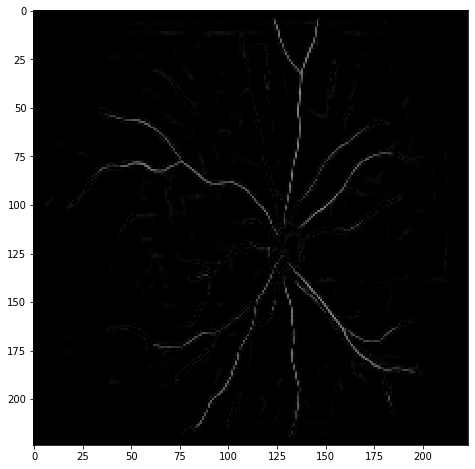

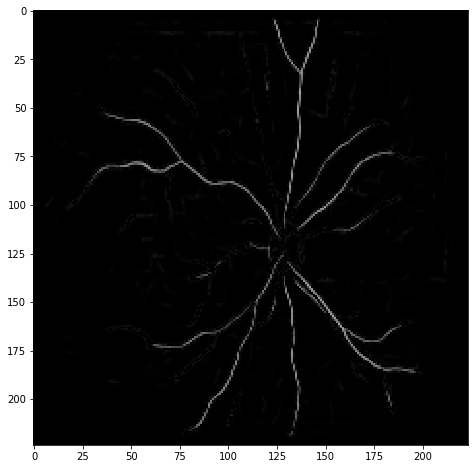

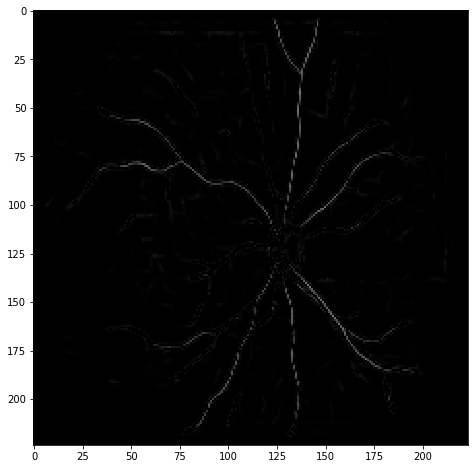

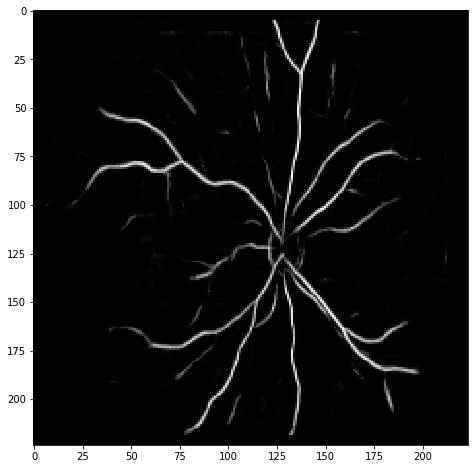

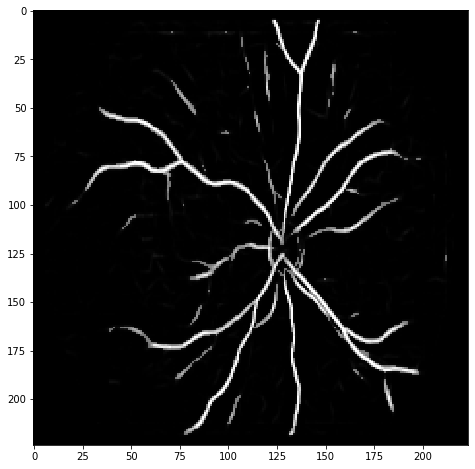

In [19]:
test_random_brightening(18168, 5, False)

In [20]:
!pwd

/users/riya/race/classifier_experiments/CNN_train/code


In [23]:
test_preds = pd.read_csv('../outputs/probabilities/balance_race_random_brightening/skeletonization_False_epoch50.csv')

In [24]:
test_preds

,img_loc,probability
0,dataset_full/test/black/101131.bmp,0.370234
1,dataset_full/test/black/101696.bmp,0.816508
2,dataset_full/test/black/101704.bmp,0.996348
3,dataset_full/test/black/101708.bmp,0.817873
4,dataset_full/test/black/101710.bmp,0.997223
...,...,...
905,dataset_full/test/white/99948.bmp,0.000221
906,dataset_full/test/white/99960.bmp,0.000127
907,dataset_full/test/white/99969.bmp,0.000032
908,dataset_full/test/white/99970.bmp,0.000003


In [32]:
auc = get_auc('../outputs/probabilities/balance_race_random_brightening/skeletonization_False_epoch50.csv')

In [33]:
auc

0.9661

In [34]:
auc_skel = get_auc('../outputs/probabilities/balance_race_random_brightening/skeletonization_True_epoch50.csv')

In [35]:
auc_skel

0.9464

## Brightening Sums

In [3]:
def visualize_system_brightening_images(img_id, brighten_sums, skeleton = False): 
    
    num_images = len(brighten_sums)
    
    img = np.array(Image.open(f"/users/riya/race/dataset/segmentations/{img_id}.bmp"))
    img = np.repeat(img[:, :, np.newaxis], 3, axis=2).reshape((480,640,3))
        
    for i in range(num_images):
        visualize_image = systemic_brightening(img, skeleton, 'below', 'brighten', brighten_sums[i])
        visualize_image2 = systemic_brightening(img, skeleton, 'below', 'dull', brighten_sums[i])
        # visualize_image2 = systemic_brightening(img, skeleton, 'above', brighten_sums[i])
        
        # bad code here
        print('larger vessels brightened by, ',brighten_sums[i])
        plt.imshow(visualize_image, interpolation = 'nearest')
        plt.gcf().set_size_inches(8,8)
        plt.show()
        
        print('smaller vessels dulled by, ',brighten_sums[i])
        plt.imshow(visualize_image2, interpolation = 'nearest')
        plt.gcf().set_size_inches(8,8)
        plt.show()

larger vessels brightened by,  0


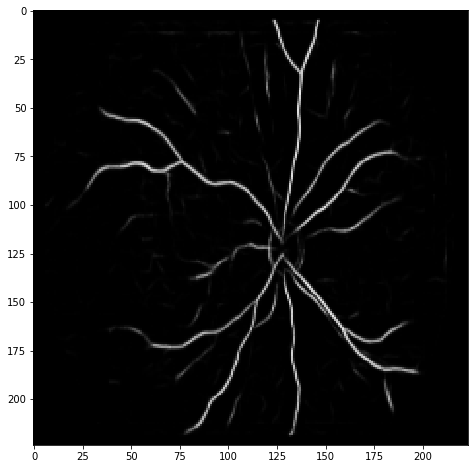

smaller vessels dulled by,  0


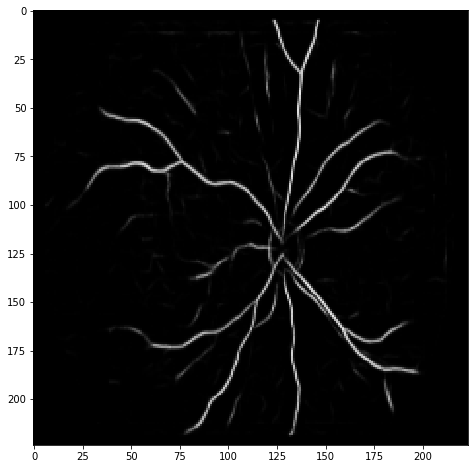

larger vessels brightened by,  30


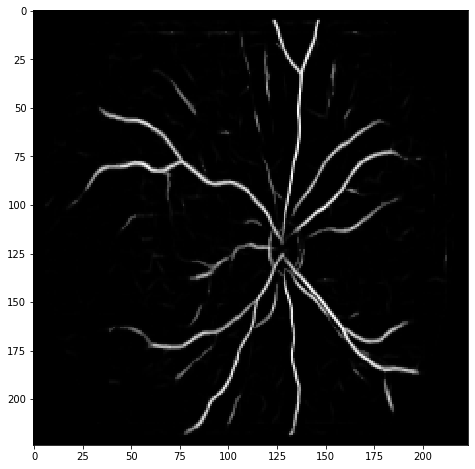

smaller vessels dulled by,  30


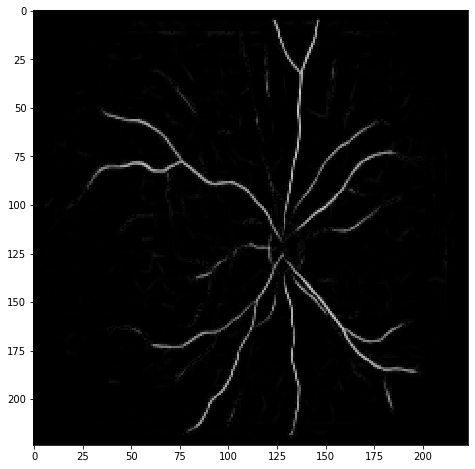

larger vessels brightened by,  60


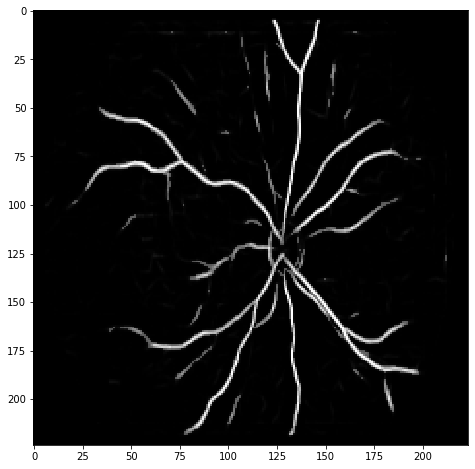

smaller vessels dulled by,  60


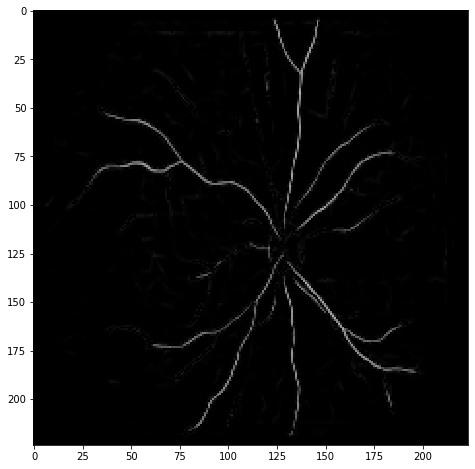

larger vessels brightened by,  90


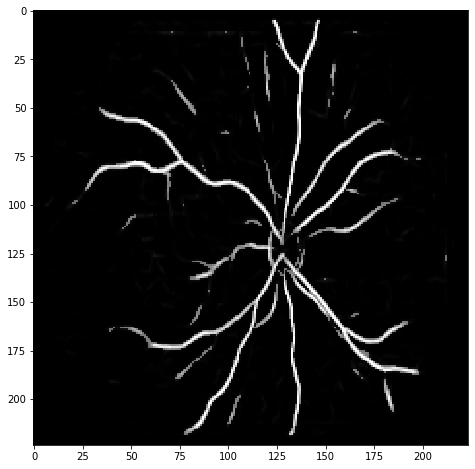

smaller vessels dulled by,  90


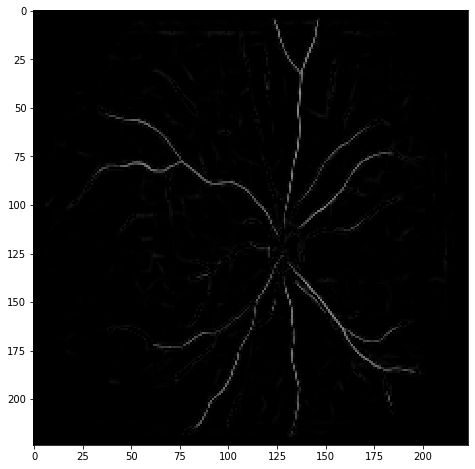

larger vessels brightened by,  120


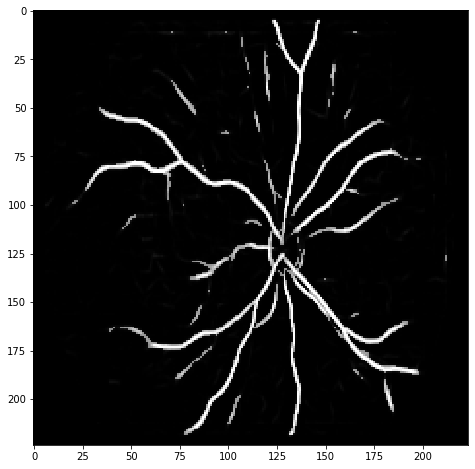

smaller vessels dulled by,  120


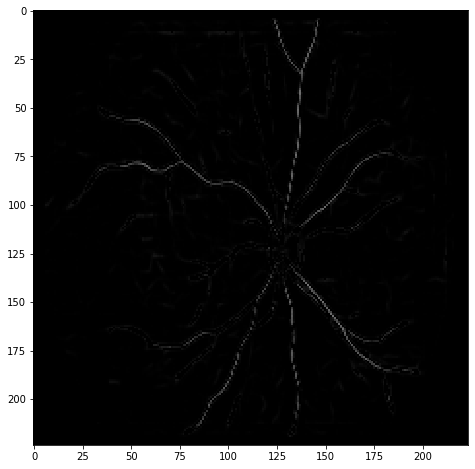

larger vessels brightened by,  150


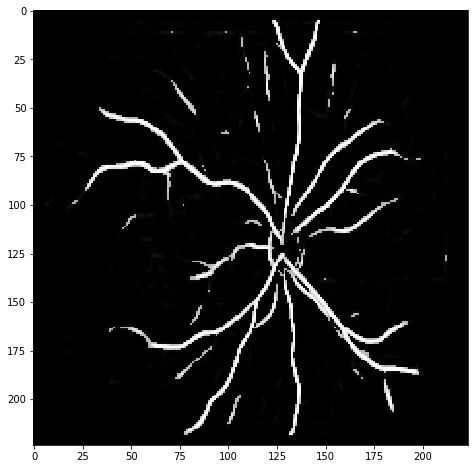

smaller vessels dulled by,  150


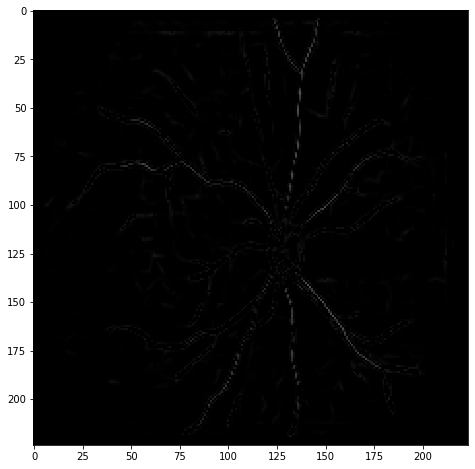

In [4]:
brighten_sums_arr = [0, 30, 60, 90, 120, 150]
visualize_system_brightening_images(18168, brighten_sums_arr, False)

In [64]:
def make_systemic_brightening_vertical_stack(img_id, intensity_change, brighten_sum,
                                            skeleton = False): # per image
    img = mpimg.imread(f"/users/riya/race/dataset/segmentations/{img_id}.bmp")
    img = np.repeat(img[:, :, np.newaxis], 3, axis=2).reshape((480,640,3))
    
    if intensity_change == 'brighten':
        visualize_image = systemic_brightening(img, skeleton, 'below', 'brighten', brighten_sum)

    if intensity_change == 'dull':
        visualize_image = systemic_brightening(img, skeleton, 'below', 'dull', brighten_sum)
    
    return visualize_image

In [65]:
def make_systemic_brightening_horizontal_stack(img_id, intensity_change, brighten_sum,
                                            skeleton = False): # per image
    img = mpimg.imread(f"/users/riya/race/dataset/segmentations/{img_id}.bmp")
    img = np.repeat(img[:, :, np.newaxis], 3, axis=2).reshape((480,640,3))
    
    if intensity_change == 'brighten':
        visualize_image = systemic_brightening(img, skeleton, 'below', 'brighten', brighten_sum)

    if intensity_change == 'dull':
        visualize_image = systemic_brightening(img, skeleton, 'below', 'dull', brighten_sum)
    
    return visualize_image

In [66]:
# apply to each brighten_sum
brighten_sums_arr = [0, 30, 60, 90, 120, 150]

<Figure size 432x288 with 0 Axes>

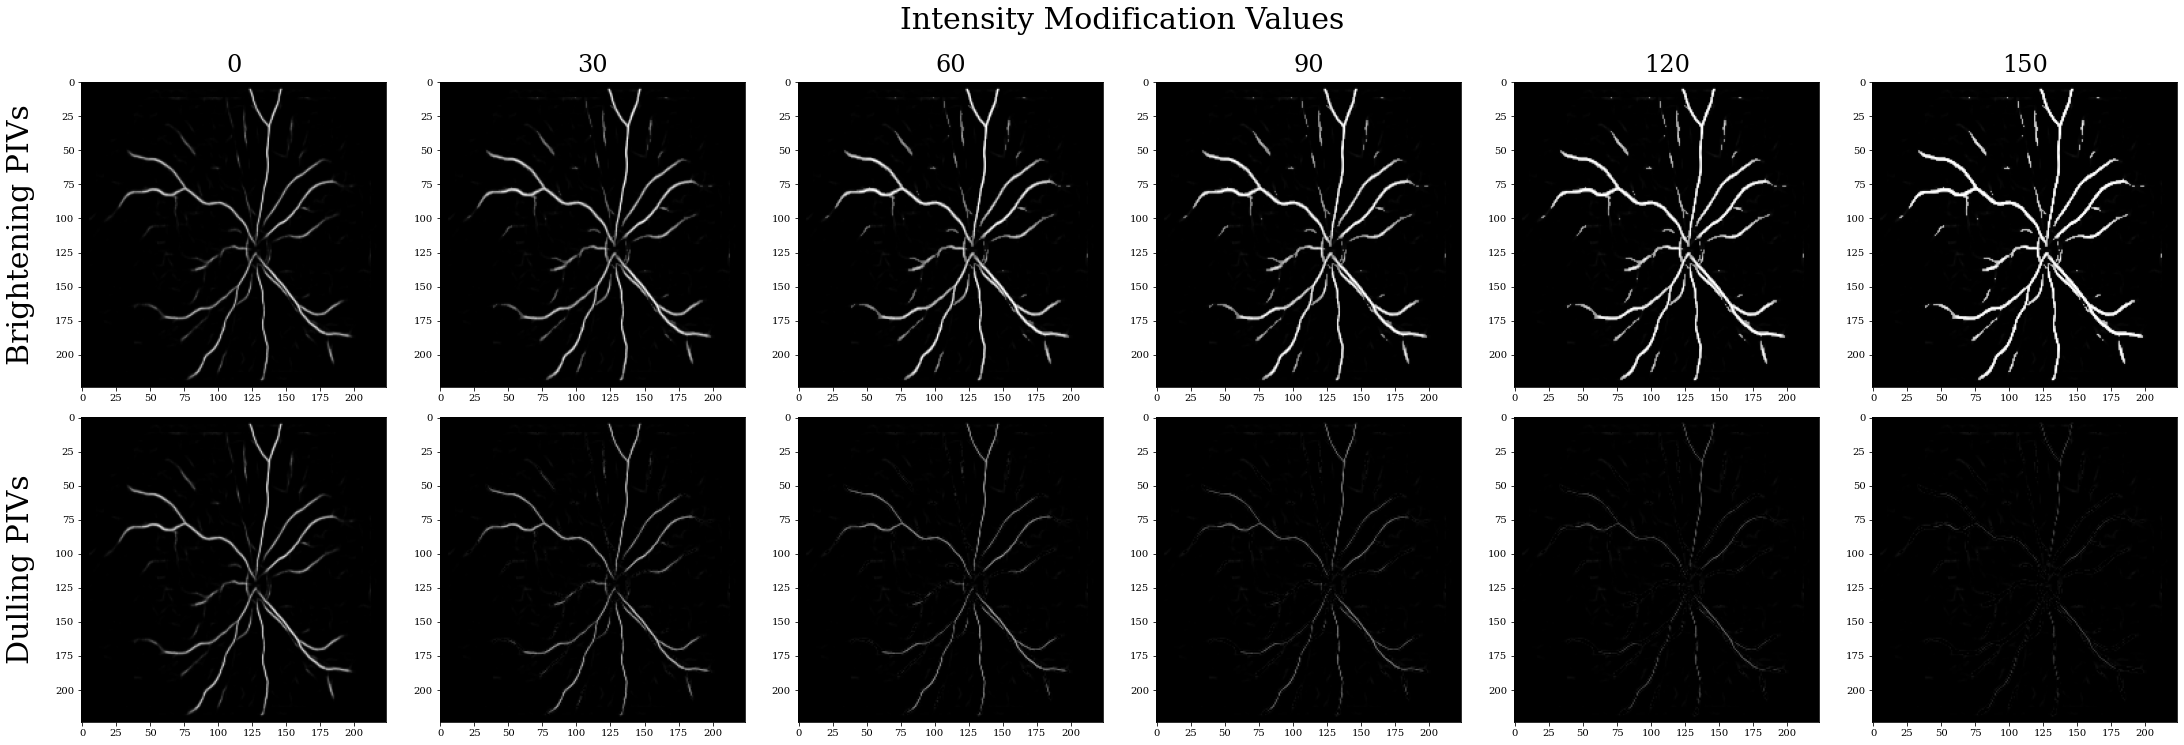

In [67]:
plt.rcParams["font.family"] = 'serif'
plt.figure()

f, axarr = plt.subplots(2, 6)

f.suptitle('Intensity Modification Values', size = 30,y = 1.03, fontfamily = 'serif')

f.set_figheight(10)
f.set_figwidth(30)

f.tight_layout()

for i in range(len(brighten_sums_arr)):
    display_img1 = make_systemic_brightening_vertical_stack(18168, 'brighten', brighten_sums_arr[i])
    display_img2 = make_systemic_brightening_vertical_stack(18168, 'dull', brighten_sums_arr[i])

    # axarr[i].set_xticks([])
    axarr[0, i].imshow(display_img1)
    axarr[1, i].imshow(display_img2)
    
    axarr[0, i].set_title(f'{brighten_sums_arr[i]}', fontsize=24, pad = 10)

axarr[0, 0].set_ylabel('Brightening PIVs', size = 30, labelpad = 20)
axarr[1, 0].set_ylabel('Dulling PIVs', size = 30, labelpad = 20)

plt.show()

In [12]:
def make_systemic_brightening_roc_plot(path, epoch, brighten_sums, 
                  insert_indexes = [], my_paths = [], my_labels=[]): # up to 50, early stopping
    
    # we only have thresholding below cases (where pixels are untouched below the threshold of 20)
    
    label = ''
    
    files=os.listdir(path)
    paths = [p for p in files if p.endswith(str(epoch) + '.csv')]
    
    final_paths = []
    labels_arr = []
    img_counter = len(brighten_sums)
        
    for i in range(img_counter):
        for j in range(len(paths)):
            path_nums = re.findall(r'\d+', paths[j])

            if len(path_nums) == 3: # means 2 radiuses, as expected
                brighten_sum = path_nums[0] # last is epoch number, 50
                if brighten_sum == brighten_sums[i] and paths[j] not in final_paths:
                    final_paths = np.append(final_paths, paths[j])
                    labels_arr = np.append(labels_arr, paths[j])
                    img_counter -= 1

    # # incase something is missed :(, I can insert it here.
    for i in range(len(insert_indexes)):
        final_paths = np.insert(final_paths, insert_indexes[i], my_paths[i]) 
        labels_arr = np.insert(labels_arr, insert_indexes[i], my_labels[i])
    
    # final_paths = ['original_epoch50.csv']
    
    print(final_paths)
    print(labels_arr)

    for i in range(len(final_paths)):
        test_predictions = pd.read_csv(path + final_paths[i])
    
        race_column = [0] * len(test_predictions)

        for j in range(len(test_predictions)):

            if (test_predictions['img_loc'][j].find('black') != -1):
                race_column[j] = 0
            elif (test_predictions['img_loc'][j].find('white') != -1):
                race_column[j] = 1

        test_predictions['race'] = race_column
        
        # return test_predictions

        black_predictions = test_predictions[test_predictions['race'] == 0]        
        white_predictions = test_predictions[test_predictions['race'] == 1]
        
        # AUC TIME!
        
        fpr, tpr, _ = metrics.roc_curve(test_predictions['race'],  1 - test_predictions['probability'])
        auc = metrics.roc_auc_score(test_predictions['race'], 1 - test_predictions['probability'])
        auc = np.round(auc, 4)
        
        # Overall Kappa TIME!
        kappa_labels = (test_predictions['probability'] < 0.5).astype(int) 
        # this gives prob of the black class 
        kappa = metrics.cohen_kappa_score(test_predictions['race'], kappa_labels) 
        # actual labels, probabilities   
        kappa = np.round(kappa, 4) 
        
        # White ACC time!
        
        # print(white_predictions['race'])
        # print(1 - white_predictions['probability']) 
        
        white_acc = get_acc(white_predictions['race'],  1 - white_predictions['probability']) 
        # 1 - to get the probability of the white class!
        
        # Black ACC time
        
        black_acc = get_acc(black_predictions['race'],  1 - black_predictions['probability']) # black class probability
                          
    
        plt.plot(fpr,tpr,label= labels_arr[i] + ", auc="+str(auc) + ", kappa ="+str(kappa) + ", white_acc ="+str(white_acc) 
                + ", black_acc ="+str(black_acc))

    plt.legend(loc=4)
    plt.show()      

['systemic_dulled_by_30_above_20_epoch50.csv'
 'systemic_brightening_by_30_above_20_epoch50.csv'
 'systemic_brightening_by_60_above_20_epoch50.csv'
 'systemic_dulled_by_60_above_20_epoch50.csv'
 'systemic_dulled_by_90_above_20_epoch50.csv'
 'systemic_brightening_by_90_above_20_epoch50.csv'
 'systemic_brightening_by_120_above_20_epoch50.csv'
 'systemic_brightening_by_150_above_20_epoch50.csv']
['systemic_dulled_by_30_above_20_epoch50.csv'
 'systemic_brightening_by_30_above_20_epoch50.csv'
 'systemic_brightening_by_60_above_20_epoch50.csv'
 'systemic_dulled_by_60_above_20_epoch50.csv'
 'systemic_dulled_by_90_above_20_epoch50.csv'
 'systemic_brightening_by_90_above_20_epoch50.csv'
 'systemic_brightening_by_120_above_20_epoch50.csv'
 'systemic_brightening_by_150_above_20_epoch50.csv']


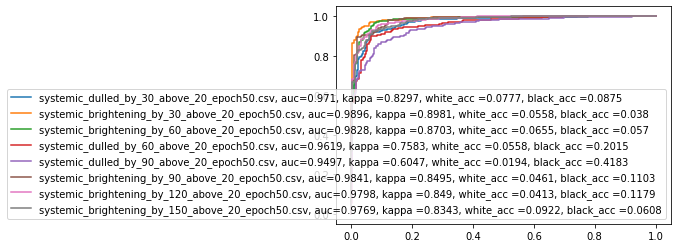

In [13]:
brighten_sums_string_arr = ['0', '30', '60', '90', '120', '150']
make_systemic_brightening_roc_plot("./CNN_train/outputs/probabilities/#9(systemic_brightening)/", 
                                   50, brighten_sums_string_arr)

Perhaps look at the number of images predicted white, or the number of white images incorrectly predicted. Let's do that!

## Random Pixels

In [4]:
def visualize_random_images(img_id, brighten_sums, median_number_of_pixels, skeleton, average_nonzero_pixels): 
    
    num_images = len(brighten_sums)
    
    img = np.array(Image.open(f"/users/riya/race/dataset/segmentations/{img_id}.bmp"))
    img = np.repeat(img[:, :, np.newaxis], 3, axis=2).reshape((480,640,3))
        
    for i in range(num_images):
        visualize_image = randomly_distribute(img, skeleton, average_nonzero_pixels, median_number_of_pixels, brighten_sums[i])
        
        # bad code here
        print('brightened by, ',brighten_sums[i])
        plt.imshow(visualize_image, interpolation = 'nearest')
        plt.gcf().set_size_inches(8,8)
        plt.show()

In [5]:
number_of_pixels = 11170 # median is 11170.5

brighten_sums_arr = [0, 20, 40, 60, 80, 100, 120]
visualize_random_images(18168, brighten_sums_arr, number_of_pixels, False, True)

13047


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

brightened by,  0


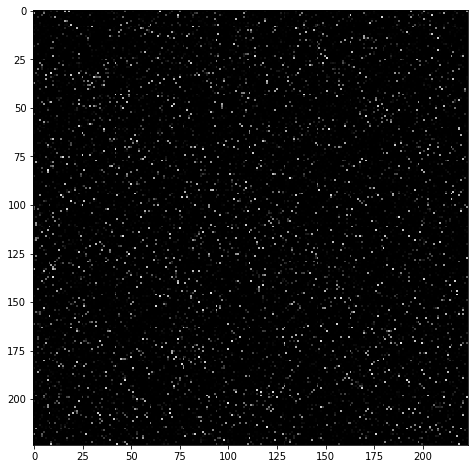

brightened by,  20


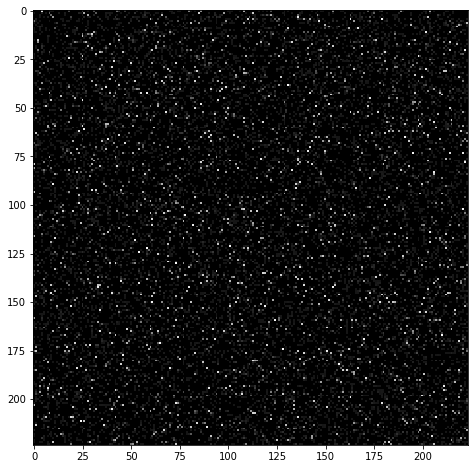

brightened by,  40


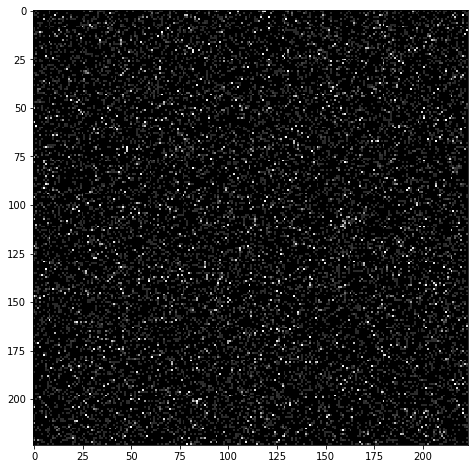

brightened by,  60


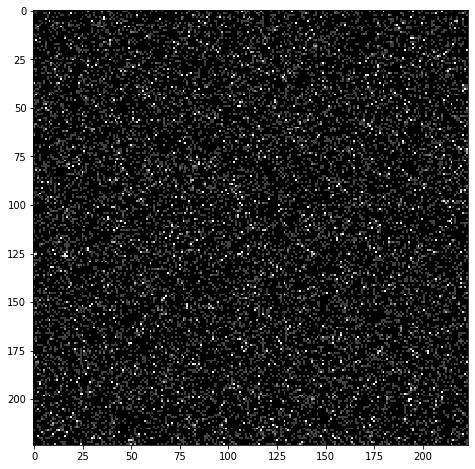

brightened by,  80


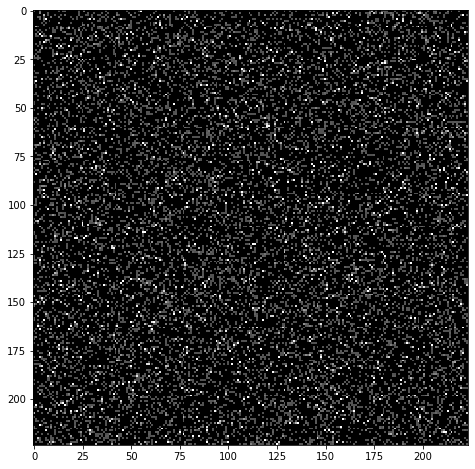

brightened by,  100


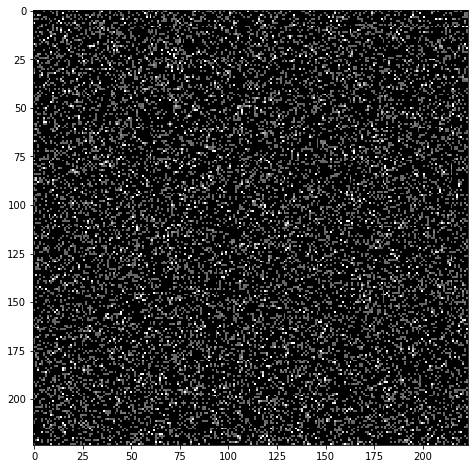

brightened by,  120


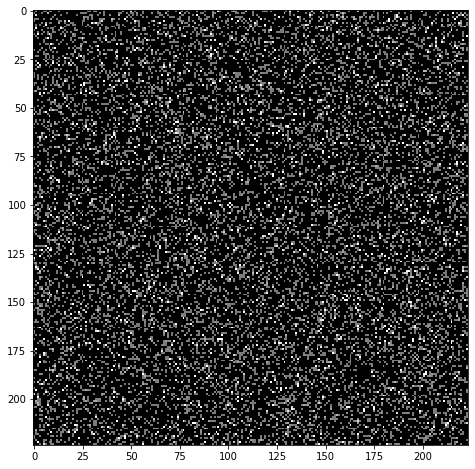

In [4]:
brighten_sums_arr = [0, 20, 40, 60, 80, 100, 120]
visualize_random_images(18168, brighten_sums_arr, False)

brightened by,  0


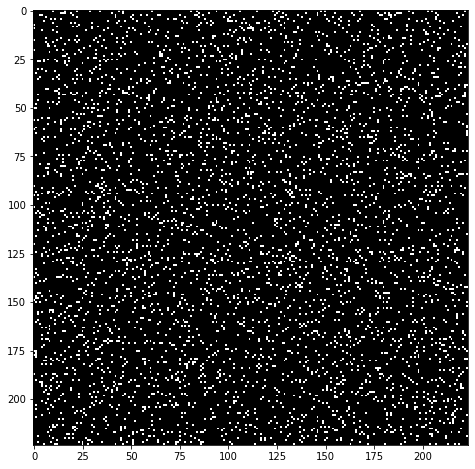

In [8]:
visualize_random_images(18168, [0], True)

In [17]:
def make_random_roc_plot(path, epoch, brighten_sums, 
                  insert_indexes = [], my_paths = [], my_labels=[]): # up to 50, early stopping
        
    label = ''
    
    files=os.listdir(path)
    paths = [p for p in files if p.endswith(str(epoch) + '.csv')]
    
    final_paths = []
    labels_arr = []
    img_counter = len(brighten_sums)
        
    for i in range(img_counter):
        for j in range(len(paths)):
            path_nums = re.findall(r'\d+', paths[j])

            if len(path_nums) == 2: # means 2 radiuses, as expected
                brighten_sum = path_nums[0] # last is epoch number, 50
                if brighten_sum == brighten_sums[i] and paths[j] not in final_paths:
                    final_paths = np.append(final_paths, paths[j])
                    labels_arr = np.append(labels_arr, paths[j])
                    img_counter -= 1

    # # incase something is missed :(, I can insert it here.
    for i in range(len(insert_indexes)):
        final_paths = np.insert(final_paths, insert_indexes[i], my_paths[i]) 
        labels_arr = np.insert(labels_arr, insert_indexes[i], my_labels[i])
    
    final_paths = ['original_epoch50.csv']
    
    print(final_paths)
    print(labels_arr)

    for i in range(len(final_paths)):
        test_predictions = pd.read_csv(path + final_paths[i])
    
        race_column = [0] * len(test_predictions)

        for j in range(len(test_predictions)):

            if (test_predictions['img_loc'][j].find('black') != -1):
                race_column[j] = 0
            elif (test_predictions['img_loc'][j].find('white') != -1):
                race_column[j] = 1

        test_predictions['race'] = race_column
        
        # return test_predictions

        black_predictions = test_predictions[test_predictions['race'] == 0]        
        white_predictions = test_predictions[test_predictions['race'] == 1]
        
        # AUC TIME!
        
        fpr, tpr, _ = metrics.roc_curve(test_predictions['race'],  1 - test_predictions['probability'])
        auc = metrics.roc_auc_score(test_predictions['race'], 1 - test_predictions['probability'])
        auc = np.round(auc, 4)
        
        # Overall Kappa TIME!
        kappa_labels = (test_predictions['probability'] < 0.5).astype(int) 
        # this gives prob of the black class 
        kappa = metrics.cohen_kappa_score(test_predictions['race'], kappa_labels) 
        # actual labels, probabilities   
        kappa = np.round(kappa, 4) 
        
        # White ACC time!
        
        # print(white_predictions['race'])
        # print(1 - white_predictions['probability']) 
        
        white_acc = get_acc(white_predictions['race'],  1 - white_predictions['probability']) 
        # 1 - to get the probability of the white class!
        
        # Black ACC time
        
        black_acc = get_acc(black_predictions['race'],  1 - black_predictions['probability']) # black class probability
                          
    
        plt.plot(fpr,tpr,label= labels_arr[i] + ", auc="+str(auc) + ", kappa ="+str(kappa) + ", white_acc ="+str(white_acc) 
                + ", black_acc ="+str(black_acc))

    plt.legend(loc=4)
    plt.show()       

['original_epoch50.csv']
['shadow_regions_dark_center_60_skeletonized_epoch50.csv'
 'shadow_regions_dark_center_60_epoch50.csv'
 'shadow_regions_dark_background_60_epoch50.csv'
 'shadow_regions_dark_background_60_skeletonized_epoch50.csv'
 'shadow_regions_dark_background_120_epoch50.csv'
 'shadow_regions_dark_center_120_epoch50.csv'
 'shadow_regions_dark_center_120_skeletonized_epoch50.csv'
 'shadow_regions_dark_background_120_skeletonized_epoch50.csv']


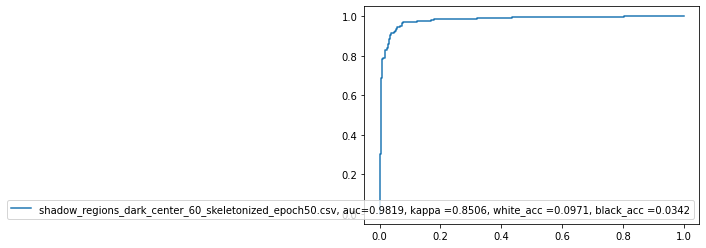

In [18]:
sum_strings = ['0', '20', '40', '60', '80', '100', '120']
make_random_roc_plot("./CNN_train/outputs/probabilities/", 50, sum_strings,
                     insert_indexes = [], my_paths = [], my_labels=[])

In [19]:
os.listdir("/users/riya/race/dataset/segmentations/")

['101934.bmp',
 '82379.bmp',
 '87427.bmp',
 '49236.bmp',
 '45251.bmp',
 '87380.bmp',
 '39426.bmp',
 '43868.bmp',
 '101127.bmp',
 '102795.bmp',
 '75672.bmp',
 '96850.bmp',
 '84991.bmp',
 '102482.bmp',
 '76802.bmp',
 '100470.bmp',
 '87351.bmp',
 '101709.bmp',
 '92816.bmp',
 '50212.bmp',
 '96908.bmp',
 '51452.bmp',
 '44598.bmp',
 '71523.bmp',
 '39208.bmp',
 '107523.bmp',
 '18158.bmp',
 '38448.bmp',
 '106415.bmp',
 '70415.bmp',
 '92773.bmp',
 '60147.bmp',
 '104340.bmp',
 '90781.bmp',
 '33352.bmp',
 '33887.bmp',
 '30626.bmp',
 '34738.bmp',
 '40791.bmp',
 '13223.bmp',
 '102388.bmp',
 '101948.bmp',
 '81671.bmp',
 '17219.bmp',
 '12547.bmp',
 '91455.bmp',
 '30074.bmp',
 '25619.bmp',
 '101999.bmp',
 '74359.bmp',
 '9161.bmp',
 '47090.bmp',
 '88766.bmp',
 '45062.bmp',
 '17390.bmp',
 '68355.bmp',
 '84360.bmp',
 '19764.bmp',
 '96167.bmp',
 '34453.bmp',
 '47356.bmp',
 '48583.bmp',
 '94632.bmp',
 '87275.bmp',
 '45403.bmp',
 '98123.bmp',
 '98684.bmp',
 '50179.bmp',
 '29431.bmp',
 '70008.bmp',
 '34744.b

## Half Skeletonize

In [3]:
def visualize_skeleton_images(img_id, skeleton_radiuses): 
    
    # if doing just shadow: shadow_radiuses is radius of shadow circle
    # if doing shadow rings, shadow_rings is array of array of outer/inner ring radiuses
    
    num_images = len(skeleton_radiuses)
    
    
    img = np.array(Image.open(f"/users/riya/race/dataset/segmentations/{img_id}.bmp"))
    img = np.repeat(img[:, :, np.newaxis], 3, axis=2).reshape((480,640,3))
    
    # based on checksums, bc function is. 
    # if we get one of those duplicates/incorrect images, will manually put disk center, or change img
    
    QA_csv, checksum_dict = checksum("../optic_disk/DeepROP/quality_assurance/QA.csv")
    disk_center = determine_image_center(img, (224, 224), QA_csv, checksum_dict) 
    
    print(disk_center)
    
    
    # write if conditions for other scenarios as I need to visualize them
    
    for i in range(num_images):
        skeleton_center_img = half_skeletonize(img, disk_center, skeleton_radiuses[i], 
                                         'skeleton_center') # image_size = (224, 224)
        pain = half_skeletonize(img, disk_center, skeleton_radiuses[i], 
                                       'skeleton_background')
        
        # bad code here
        print('skeleton center, ',skeleton_radiuses[i])
        plt.imshow(skeleton_center_img, interpolation = 'nearest')
        plt.gcf().set_size_inches(8,8)
        plt.show()
        
        print('skeleton background, ',skeleton_radiuses[i])
        plt.imshow(pain, interpolation = 'nearest')
        plt.gcf().set_size_inches(8,8)
        plt.show()

100%|██████████| 3371/3371 [00:10<00:00, 328.28it/s]


(129, 123)
skeleton center,  [0, 15]


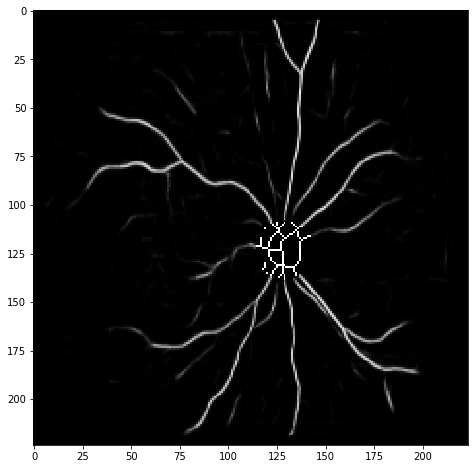

skeleton background,  [0, 15]


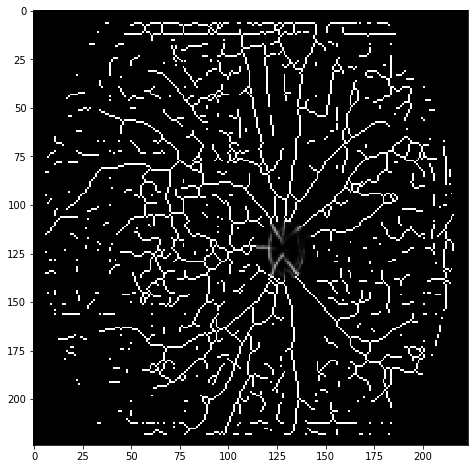

skeleton center,  [0, 30]


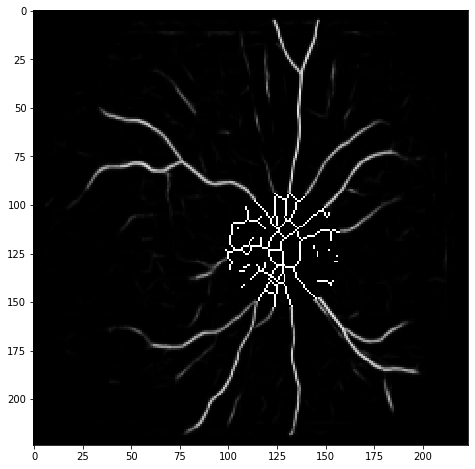

skeleton background,  [0, 30]


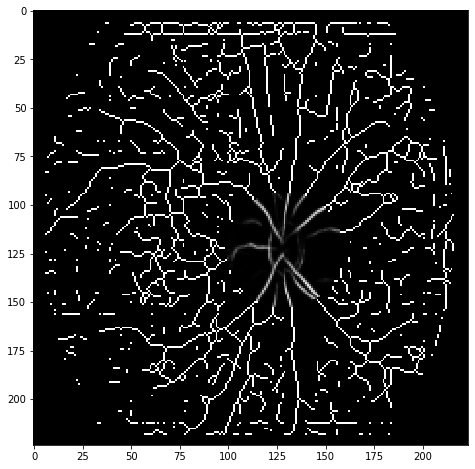

skeleton center,  [0, 45]


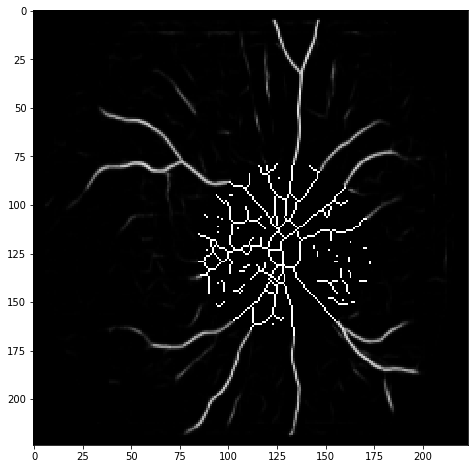

skeleton background,  [0, 45]


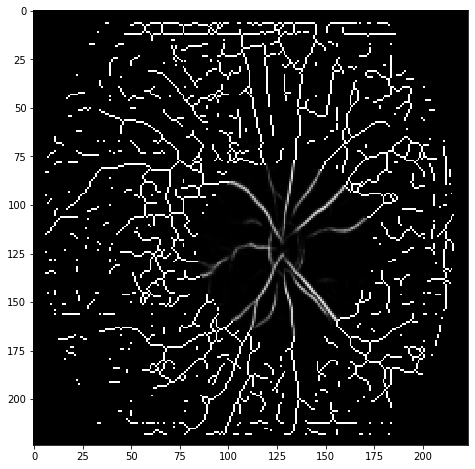

skeleton center,  [0, 60]


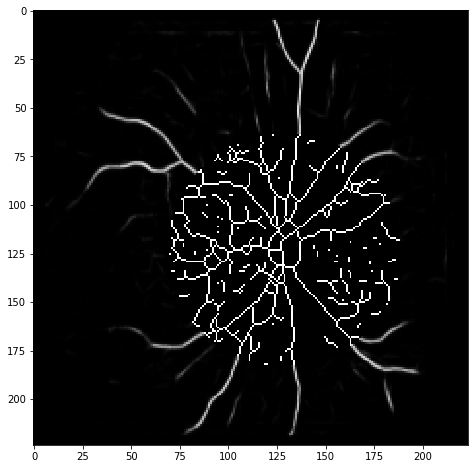

skeleton background,  [0, 60]


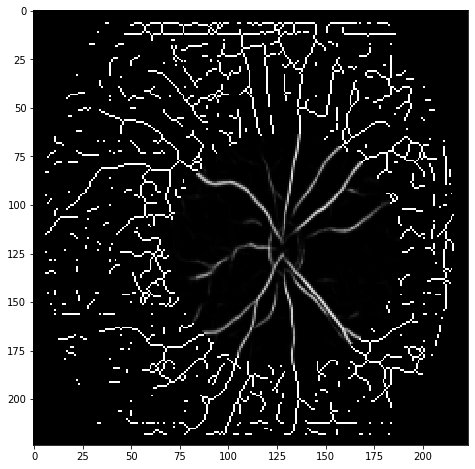

skeleton center,  [0, 75]


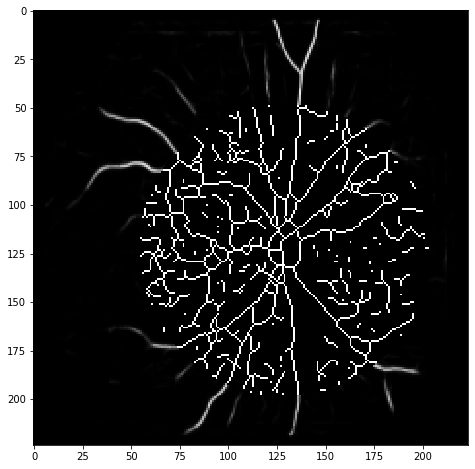

skeleton background,  [0, 75]


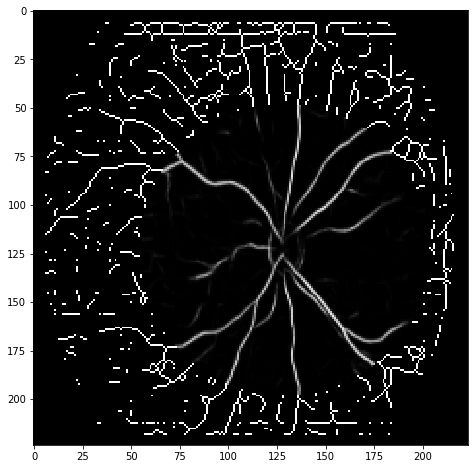

skeleton center,  [0, 90]


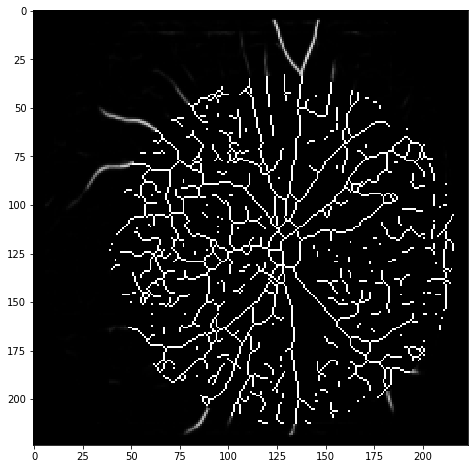

skeleton background,  [0, 90]


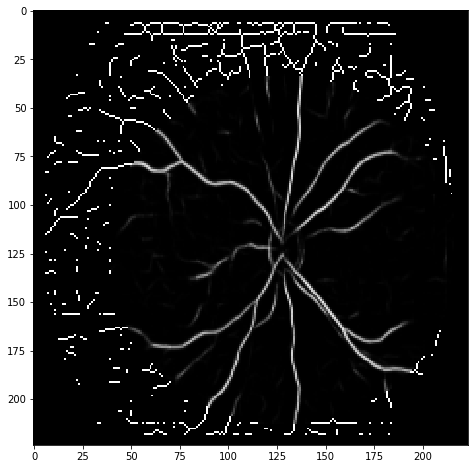

skeleton center,  [0, 105]


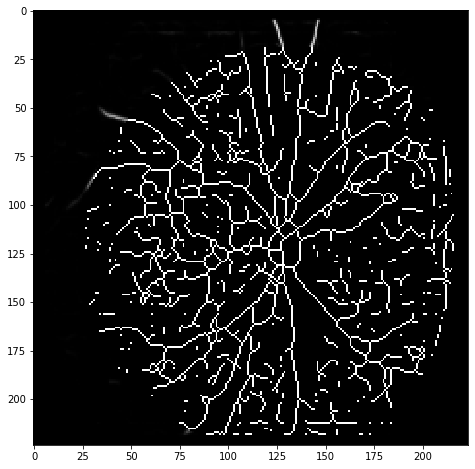

skeleton background,  [0, 105]


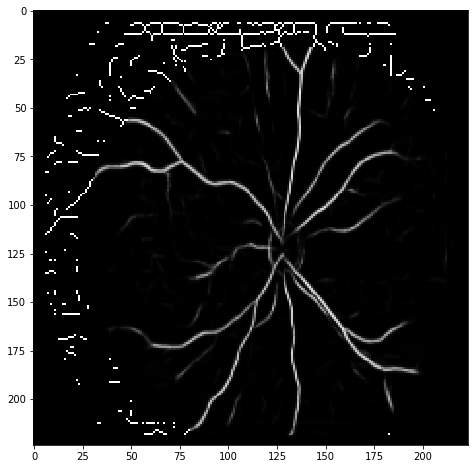

skeleton center,  [0, 120]


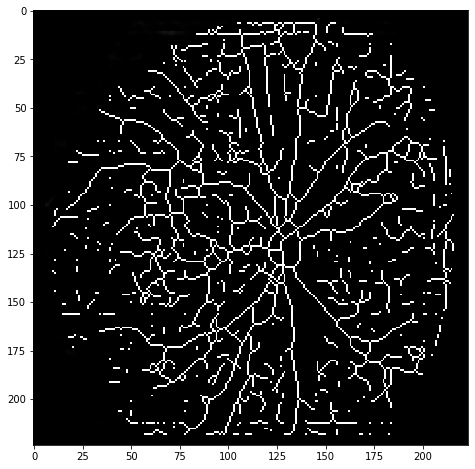

skeleton background,  [0, 120]


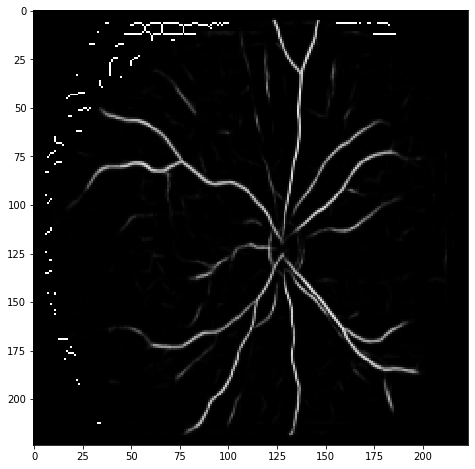

In [4]:
skeleton_radiuses = [[0, 15], [0, 30], [0,45], [0,60], [0,75], [0,90], [0, 105], [0,120]]
visualize_skeleton_images(18168, skeleton_radiuses)

In [109]:
def make_skel_roc_plot(path, epoch, skeleton_radiuses, region, 
                  insert_indexes = [], my_paths = [], my_labels=[]): # up to 50, early stopping
        
    label = ''
    
    files=os.listdir(path)
    csvs = [p for p in files if p.endswith(str(epoch) + '.csv')]
    
    if region == 'skeleton_center':
        paths = [p for p in csvs if "skeleton_center" in p]
        
    elif region == 'skeleton_background':
        paths = [p for p in csvs if "skeleton_background" in p]
    
    # narrowing down paths by radiuses I Want
    # print (len(paths))
    
    final_paths = []
    labels_arr = []
    img_counter = len(skeleton_radiuses)
        
    for i in range(img_counter):
        for j in range(len(paths)):
            path_nums = re.findall(r'\d+', paths[j])

            if len(path_nums) == 3: # means 2 radiuses, as expected
                radius_arr = [path_nums[0], path_nums[1]] # last is epoch number, 50
                if radius_arr == skeleton_radiuses[i] and paths[j] not in final_paths:
                    final_paths = np.append(final_paths, paths[j])
                    labels_arr = np.append(labels_arr, "radius: " + path_nums[0] + " to " +  path_nums[1] + 
                                               " (partially skeletonized)")
                    img_counter -= 1

    # # incase something is missed :(, I can insert it here.
    for i in range(len(insert_indexes)):
        final_paths = np.insert(final_paths, insert_indexes[i], my_paths[i]) 
        labels_arr = np.insert(labels_arr, insert_indexes[i], my_labels[i])
    
    print(final_paths)
    print(labels_arr)

    for i in range(len(final_paths)):
        test_predictions = pd.read_csv(path + final_paths[i])
    
        race_column = [0] * len(test_predictions)

        for j in range(len(test_predictions)):

            if (test_predictions['img_loc'][j].find('black') != -1):
                race_column[j] = 0
            elif (test_predictions['img_loc'][j].find('white') != -1):
                race_column[j] = 1

        test_predictions['race'] = race_column
        

        # AUC TIME!
        
        fpr, tpr, _ = metrics.roc_curve(test_predictions['race'],  1 - test_predictions['probability'])
        auc = metrics.roc_auc_score(test_predictions['race'], 1 - test_predictions['probability'])
        auc = np.round(auc, 4)
        
        # AUPROC time!
        
        au_proc = metrics.average_precision_score(test_predictions['race'], 1 - test_predictions['probability'])
        au_proc = np.round(au_proc, 4)
        
        # KAPPA time!
        # need to get predicted labels (so round up or down)
        
        kappa_labels = (test_predictions['probability'] < 0.5).astype(int) 
        # this gives prob of the black class 
        kappa = metrics.cohen_kappa_score(test_predictions['race'], kappa_labels) 
        # actual labels, probabilities
        
        
        # quick test 
        
        uncommon_elements = 0 
        
        for p in range(len(kappa_labels)):
            if kappa_labels[p] != test_predictions['race'][p]:
                uncommon_elements+=1
        # print(uncommon_elements)
        # print(len(kappa_labels))
        
        kappa = np.round(kappa, 4)                             
    
        plt.plot(fpr,tpr,label= labels_arr[i] + ", auc="+str(auc) + ", auproc="+str(au_proc) + ", kappa ="+str(kappa))

    plt.legend(loc=4)
    plt.show()       

In [110]:
skeleton_string_radiuses = [['0', '15'], ['0', '30'], ['0','45'], ['0','60'], 
                            ['0','75'], ['0','90'], ['0', '105'], ['0','120']]

['half_skeletonize_skeleton_center_0_15_epoch50.csv'
 'half_skeletonize_skeleton_center_0_30_epoch50.csv'
 'half_skeletonize_skeleton_center_0_45_epoch50.csv'
 'half_skeletonize_skeleton_center_0_60_epoch50.csv'
 'half_skeletonize_skeleton_center_0_75_epoch50.csv'
 'half_skeletonize_skeleton_center_0_90_epoch50.csv'
 'half_skeletonize_skeleton_center_0_105_epoch50.csv'
 'half_skeletonize_skeleton_center_0_120_epoch50.csv']
['radius: 0 to 15 (partially skeletonized)'
 'radius: 0 to 30 (partially skeletonized)'
 'radius: 0 to 45 (partially skeletonized)'
 'radius: 0 to 60 (partially skeletonized)'
 'radius: 0 to 75 (partially skeletonized)'
 'radius: 0 to 90 (partially skeletonized)'
 'radius: 0 to 105 (partially skeletonized)'
 'radius: 0 to 120 (partially skeletonized)']


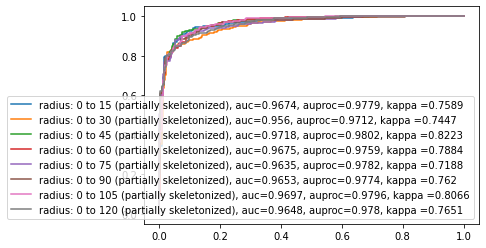

In [113]:
make_skel_roc_plot("./CNN_train/outputs/probabilities/#7(half_skeletonize)/", 50, skeleton_string_radiuses, 
                   'skeleton_center', insert_indexes = [], my_paths = [], my_labels=[])

In [112]:
!ls

CNN_train			  shadow_regions_experiment2_expanded.ipynb
CNN_visualization.ipynb		  shadow_regions_experiment3.ipynb
__pycache__			  shadow_regions_experiment4.ipynb
dataset				  train.ipynb
models				  train0.py
predictions			  train2.py
shadow_regions.ipynb		  train_half_skeletonize.py
shadow_regions_experiment2.ipynb  train_original.py


## Shadowed Images

In [ ]:
def visualize_images(img_id, skel, shadow, shadow_rings, num_rings, shadow_radiuses, img_count=0): 
    
    # if doing just shadow: shadow_radiuses is radius of shadow circle
    # if doing shadow rings, shadow_rings is array of array of outer/inner ring radiuses
    
    num_images = img_count
    
    
    img = np.array(Image.open(f"/users/riya/race/dataset/segmentations/{img_id}.bmp"))
    img = np.repeat(img[:, :, np.newaxis], 3, axis=2).reshape((480,640,3))
    
    # based on checksums, bc function is. 
    # if we get one of those duplicates/incorrect images, will manually put disk center, or change img
    
    QA_csv, checksum_dict = checksum("../../optic_disk/DeepROP/quality_assurance/QA.csv")
    disk_center = determine_image_center(img, (224, 224), QA_csv, checksum_dict) 
    
    print(disk_center)
    
    if shadow is True and shadow_rings is not True:
        num_images = len(shadow_radiuses)
    elif shadow is True and shadow_rings is True:
        num_images = len(shadow_radiuses)
    
    # write if conditions for other scenarios as I need to visualize them
    
    for i in range(num_images):
        dark_center_img = shadow_regions(img, skel, disk_center, shadow, shadow_radiuses[i], shadow_rings, num_rings,
                                         shadow_radiuses[i], 'dark_center', image_size = (224, 224))
        dark_back_img = shadow_regions(img, skel, disk_center, shadow, shadow_radiuses[i], shadow_rings, num_rings, 
                                       shadow_radiuses[i], 'dark_background', image_size = (224, 224))
        
        # bad code here
        print('dark center, ',shadow_radiuses[i])
        plt.imshow(dark_center_img, interpolation = 'nearest')
        plt.gcf().set_size_inches(8,8)
        plt.show()
        
        print('dark background, ',shadow_radiuses[i])
        plt.imshow(dark_back_img, interpolation = 'nearest')
        plt.gcf().set_size_inches(8,8)
        plt.show()

100%|██████████| 3371/3371 [00:10<00:00, 326.72it/s]


dark center,  [0, 30]


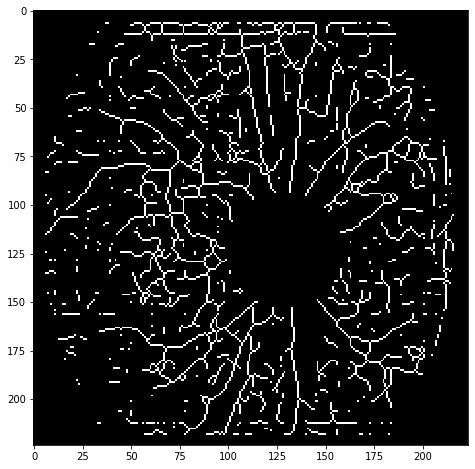

dark background,  [0, 30]


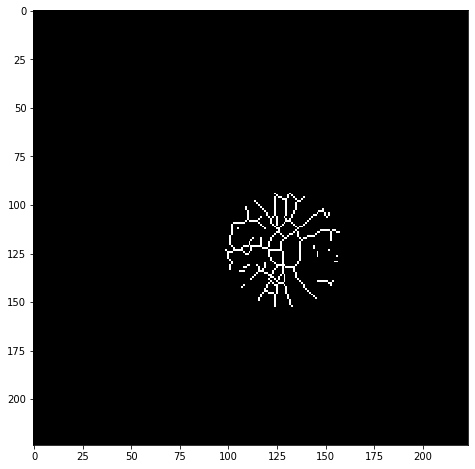

dark center,  [30, 60]


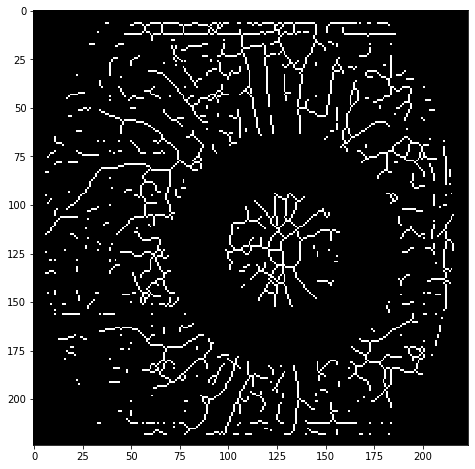

dark background,  [30, 60]


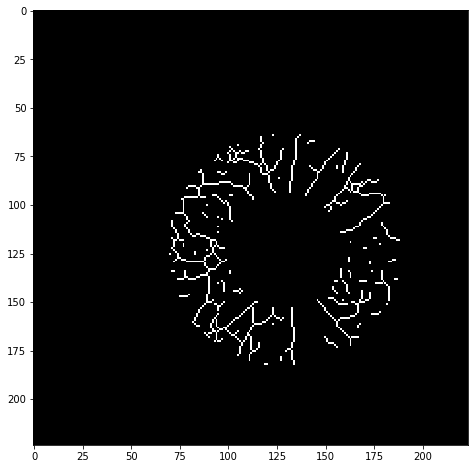

dark center,  [60, 90]


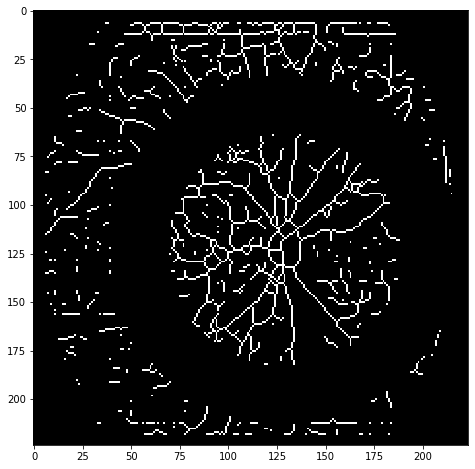

dark background,  [60, 90]


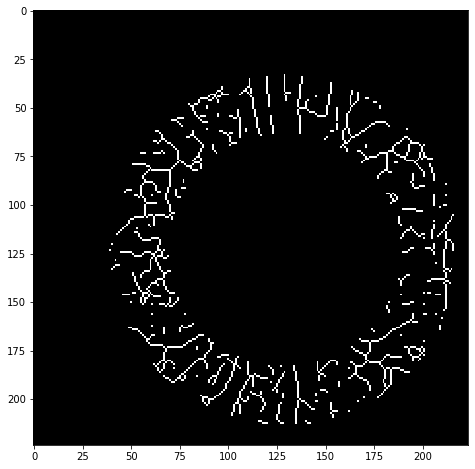

In [4]:
ring_radiuses = [[0, 30], [30, 60], [60, 90]]
visualize_images(18168, True, True, True, 1, ring_radiuses)

100%|██████████| 3371/3371 [00:13<00:00, 257.67it/s]


(58, 129)
dark center,  [[0, 15], [75, 90]]


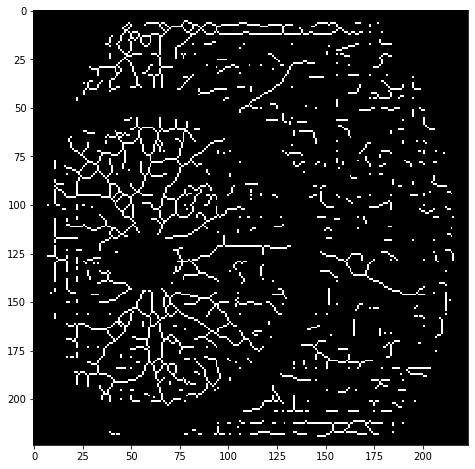

dark background,  [[0, 15], [75, 90]]


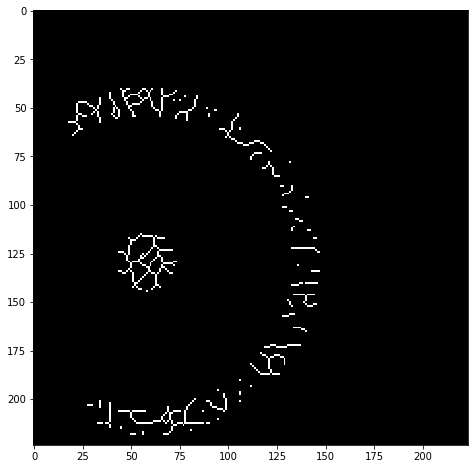

dark center,  [[0, 30], [60, 90]]


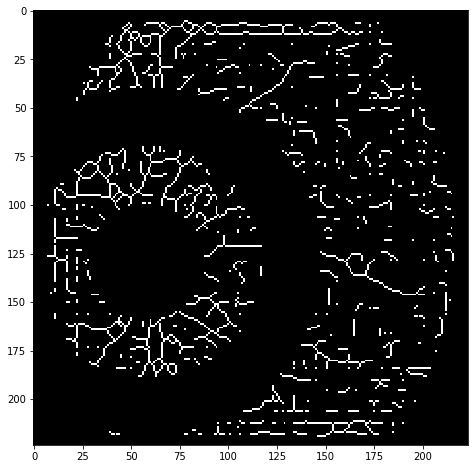

dark background,  [[0, 30], [60, 90]]


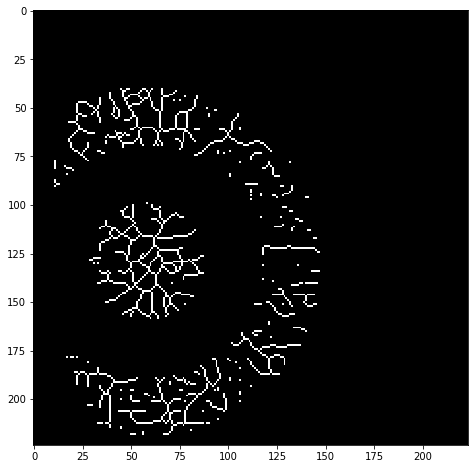

dark center,  [[0, 45], [45, 90]]


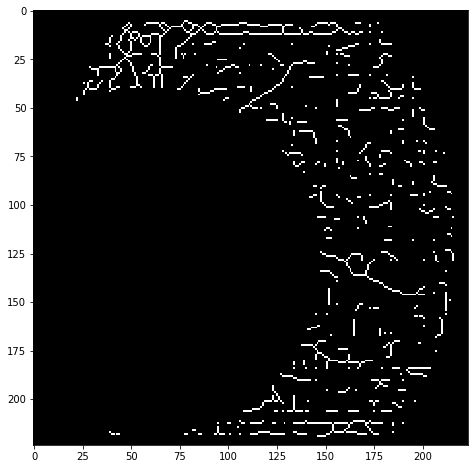

dark background,  [[0, 45], [45, 90]]


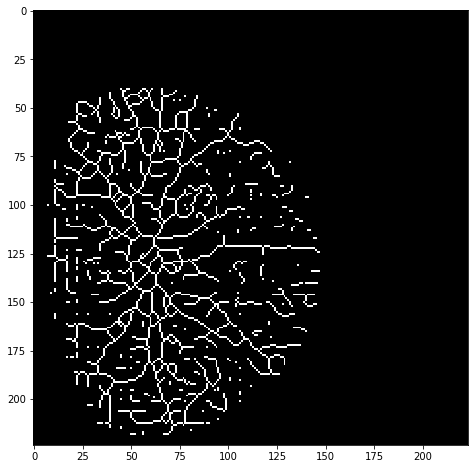

In [64]:
multi_ring_radiuses = [[[0, 15], [75,90]], [[0, 30], [60, 90]], [[0,45],[45, 90]]]
visualize_images(27313, True, True, True, 2, multi_ring_radiuses)

In [ ]:
def make_half_plot(path, epoch, skeleton, shadow, shadow_ring, shadow_radiuses, region, 
                  insert_indexes = [], my_paths = [], my_labels=[]): # up to 50, early stopping
    
    label = ''
    
    files=os.listdir(path)
    csvs = [p for p in files if p.endswith(str(epoch) + '.csv')]
    
    if skeleton:
        paths = [p for p in csvs if "skeletonized" in p or "skeletonized" in p and "shadow" not in p]
        if shadow:
            if shadow_ring:
                paths = [p for p in paths if "shadow_rings" in p or "skeletonized" in p and "shadow" not in p] # original skeletonized
            elif shadow_ring is False:
                paths = [p for p in paths if "shadow" in p and "ring" not in p or "skeletonized" in p and "shadow" not in p]
        elif shadow is False:
            paths = [p for p in paths if "skeletonized" in p and "shadow" not in p] # only original skeletonized
        
        if region == 'dark_center':
            paths = [p for p in paths if "dark_center" in p or "skeletonized" in p and "shadow" not in p]
        
        elif region == 'dark_background':
            paths = [p for p in paths if "dark_background" in p or "skeletonized" in p and "shadow" not in p]
        
    if not skeleton:
        paths = [p for p in csvs if "skeletonized" not in p or "original" in p]  
        if shadow:
            if shadow_ring:
                paths = [p for p in paths if "shadow_rings" in p or "original" in p]
            elif shadow_ring is False:
                [p for p in paths if "shadow" in p and "ring" not in p or "original" in p]
        elif shadow is False:
            [p for p in paths if "original" in p] # only original skeletonized
         
        if region == 'dark_center':
            paths = [p for p in paths if "dark_center" in p or "original" in p]
        
        elif region == 'dark_background':
            paths = [p for p in paths if "dark_background" in p or "original" in p]
    
    # narrowing down paths by radiuses I Want
    # print (len(paths))
    
    final_paths = []
    labels_arr = []
    shadow_remove = len(shadow_radiuses)

    # to improve code, can store in variables and append only at the end.
    # how to organize this such that labels and paths are in the order that I want?
    
    for j in range(len(shadow_radiuses)): # getting this original in first order.
        for i in range(len(paths)):
            
            path_nums = re.findall(r'\d+', paths[i])
            
            if len(path_nums) == 1:
                if skeleton == True and paths[i] not in final_paths:
                    labels_arr = np.append(labels_arr, "original skeletonized")
                    final_paths = np.append(final_paths, paths[i])
                elif skeleton == False and paths[i] not in final_paths:
                    labels_arr = np.append(labels_arr, "original")
                    final_paths = np.append(final_paths, paths[i])
        
    for j in range(len(shadow_radiuses)):
        for i in range(len(paths)):
            path_nums = re.findall(r'\d+', paths[i])

            if len(path_nums) == 2: # means there is 1 radius, and no rings
                if path_nums[0] == shadow_radiuses[j] and paths[i] not in final_paths: # to get them in the order I want!!!
                    # print(path_nums[0])
                    final_paths = np.append(final_paths, paths[i])
                    labels_arr = np.append(labels_arr, "radius: " + path_nums[0])
                    shadow_remove -= 1

            elif len(path_nums) == 3: # means 2 radiuses, shadow rings
                radius_arr = [path_nums[0], path_nums[1]] # last is epoch number, 50
                if radius_arr == shadow_radiuses[j] and paths[i] not in final_paths:
                    final_paths = np.append(final_paths, paths[i])
                    labels_arr = np.append(labels_arr, "radius: " + path_nums[0] + " to " +  path_nums[1] + " (ring)")
                    shadow_remove -= 1
            
            elif len(path_nums) == 5: # means 2 shadow rings, assuming ONLY 2
                radius_arr = [[path_nums[0], path_nums[1]], [path_nums[2], path_nums[3]]] # last is epoch number, 50
                if radius_arr == shadow_radiuses[j] and paths[i] not in final_paths:
                    final_paths = np.append(final_paths, paths[i])
                    labels_arr = np.append(labels_arr, "radius: " + path_nums[0] + " to " +  path_nums[1] + 
                                           ", " + path_nums[2] + " to " + path_nums[3] + " (2 rings)")
                    shadow_remove -= 1

    # # incase something is missed :(, I can insert it here.
    for i in range(len(insert_indexes)):
        final_paths = np.insert(final_paths, insert_indexes[i], my_paths[i]) 
        labels_arr = np.insert(labels_arr, insert_indexes[i], my_labels[i])
    
    print(final_paths)
    print(labels_arr)

    for i in range(len(final_paths)):
        test_predictions = pd.read_csv(path + final_paths[i])
    
        race_column = [0] * len(test_predictions)

        for j in range(len(test_predictions)):

            if (test_predictions['img_loc'][j].find('black') != -1):
                race_column[j] = 0
            elif (test_predictions['img_loc'][j].find('white') != -1):
                race_column[j] = 1

        test_predictions['race'] = race_column
        

        # AUC TIME!
        
        fpr, tpr, _ = metrics.roc_curve(test_predictions['race'],  1 - test_predictions['probability'])
        auc = metrics.roc_auc_score(test_predictions['race'], 1 - test_predictions['probability'])
        auc = np.round(auc, 4)
        
        # 
        
        # AUPROC time!
        
        au_proc = metrics.average_precision_score(test_predictions['race'], 1 - test_predictions['probability'])
        au_proc = np.round(au_proc, 4)
        
        # KAPPA time!
        # need to get predicted labels (so round up or down)
        
        kappa_labels = (test_predictions['probability'] < 0.5).astype(int) 
        # this gives prob of the black class 
        kappa = metrics.cohen_kappa_score(test_predictions['race'], kappa_labels) 
        # actual labels, probabilities
        
        
        # quick test 
        
        uncommon_elements = 0 
        
        for p in range(len(kappa_labels)):
            if kappa_labels[p] != test_predictions['race'][p]:
                uncommon_elements+=1
        # print(uncommon_elements)
        # print(len(kappa_labels))
        
        kappa = np.round(kappa, 4)                             
    
        plt.plot(fpr,tpr,label= labels_arr[i] + ", auc="+str(auc) + ", auproc="+str(au_proc) + ", kappa ="+str(kappa))

    plt.legend(loc=4)
    plt.show()       

['original_epoch50.csv'
 'shadow_rings_dark_background_0_15_75_90_epoch50.csv'
 'shadow_rings_dark_background_0_30_60_90_epoch50.csv'
 'shadow_regions_dark_background_90_epoch50.csv']
['original' 'radius: 0 to 15, 75 to 90 (2 rings)'
 'radius: 0 to 30, 60 to 90 (2 rings)'
 'radius: 0 to 45, 45 to 90 (2 rings)']
49
675
65
675
62
675
43
675


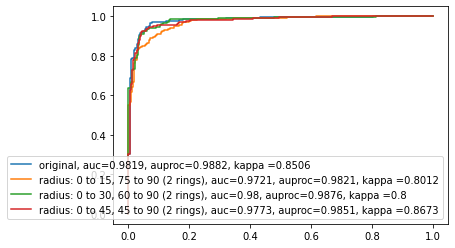

In [112]:
multi_ring_roc_radiuses = [[['0', '15'], ['75','90']], [['0', '30'], ['60', '90']], [['0','45'],['45', '90']]]

make_roc_plot("./outputs/probabilities/", 50, False, True, True, 
              multi_ring_roc_radiuses, 'dark_background',
             insert_indexes = [3], my_paths = ['shadow_regions_dark_background_90_epoch50.csv'], 
              my_labels=['radius: 0 to 45, 45 to 90 (2 rings)'])


11
['shadow_rings_dark_background_30_60_skeletonized_epoch50.csv'
 'shadow_rings_dark_background_0_30_skeletonized_epoch50.csv'
 'skeletonized_epoch50.csv'
 'shadow_rings_dark_background_60_90_skeletonized_epoch50.csv']
['radius: 30 to 60 (ring)' 'radius: 0 to 30 (ring)'
 'original skeletonized' 'radius: 60 to 90 (ring)']
['radius: 30 to 60 (ring)' 'radius: 0 to 30 (ring)'
 'original skeletonized' 'radius: 60 to 90 (ring)']
['radius: 30 to 60 (ring)' 'radius: 0 to 30 (ring)'
 'original skeletonized' 'radius: 60 to 90 (ring)']
['radius: 30 to 60 (ring)' 'radius: 0 to 30 (ring)'
 'original skeletonized' 'radius: 60 to 90 (ring)']


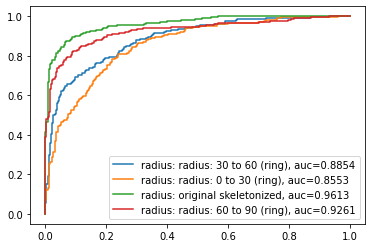

In [96]:
make_roc_plot("./outputs/probabilities/", 50, True, True, True, [['0', '30'], ['30','60'], ['60', '90']], 'dark_background')

['original_epoch50.csv' 'shadow_regions_dark_background_45_epoch50.csv'
 'shadow_regions_dark_background_60_epoch50.csv'
 'shadow_regions_dark_background_90_epoch50.csv']
['original' 'radius: 45' 'radius: 60' 'radius: 90']


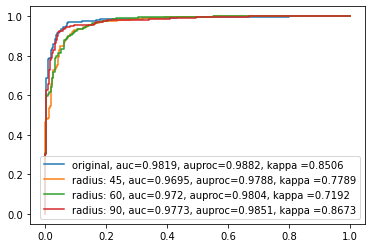

In [125]:
make_roc_plot("./outputs/probabilities/", 50, False, True, False, ['45', '60', '90'], 'dark_background')

In [ ]:
make_roc_plot("./outputs/probabilities/", 50, True, True, False, 
              ['15', '30', '45', '60', '75', '90', '105', '120'], 'dark_center',
             [1, 2], ['shadow_rings_dark_center_0_15_skeletonized_epoch50.csv', 
                      'shadow_rings_dark_center_0_30_skeletonized_epoch50.csv'], 
             ['radius: 15', 'radius: 30'])

['skeletonized_epoch50.csv'
 'shadow_rings_dark_background_45_90_skeletonized_epoch50.csv']
['original skeletonized' 'radius: 45 to 90 (ring)']


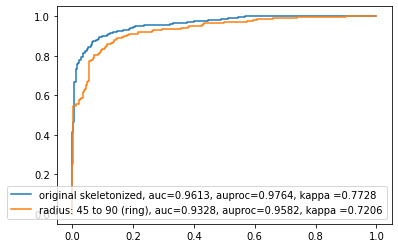

In [128]:
make_roc_plot("./outputs/probabilities/", 50, True, True, True, [['45', '90']], 'dark_background')

## Shadow Regions AUC graphs

### Regions (add-on) Results

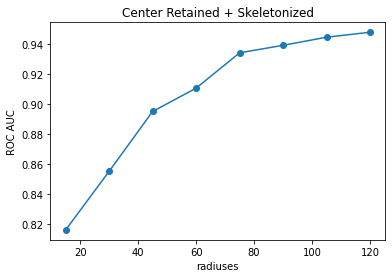

In [141]:
radiuses = [15,30,45,60,75,90,105,120]
auc = [0.8163,0.8553,0.8951,0.9106,0.9341,0.9391,0.9445,0.9478]

plt.scatter(radiuses,auc)
plt.xlabel('radiuses')
plt.ylabel('ROC AUC')
plt.title('Center Retained + Skeletonized')

plt.plot(radiuses, auc)
plt.show()

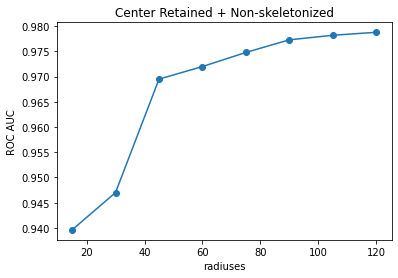

In [142]:
auc_non_skel =  [0.9396, 0.947, 0.9695, 0.9720, 0.9748, 0.9773, 0.9782, 0.9788]

plt.scatter(radiuses,auc_non_skel)
plt.plot(radiuses, auc_non_skel)
plt.xlabel('radiuses')
plt.ylabel('ROC AUC')
plt.title('Center Retained + Non-skeletonized')

plt.show()

In [1]:
auc2 =   [0.9573, 0.9696, 0.9608, 0.9485, 0.9385, 0.8807, 0.8577, 0.7941]

plt.scatter(radiuses,auc2)
plt.plot(radiuses, auc2)
plt.xlabel('radiuses')
plt.ylabel('ROC AUC')
plt.title('Background Retained + Non-skeletonized')

plt.show()

NameError: name 'plt' is not defined

### Ring Results Thorugh Visualization

In [44]:
auc_skel_15_center_preserved = [0.9613, 0.8163, 0.7754, 0.8408, 0.8772, 0.8974, 0.9128]
auc_skel_30_center_preserved = [0.9613, 0.8553, 0.8854, 0.9261]

auc_non_skel_15_center_preserved = [0.9819, 0.9396, 0.8698, 0.8757, 0.8648, 0.9126, 0.9046]
auc_non_skel_30_center_preserved = [0.9819, 0.947, 0.8895, 0.9264]

radiuses_15 = ['original','0-15', '15-30', '30-45', '45-60', '60-75', '75-90']
radiuses_30 = ['original','0-30', '30-60', '60-90']

In [56]:
area_15 = 15 * np.pi * 15

In [57]:
area_30 = 900 * np.pi - area_15

In [58]:
area_45 = 45*45 * np.pi - area_30

In [59]:
area_60 = 3600 * np.pi - area_45

In [60]:
area_75 = 75*75 * np.pi - area_60

In [61]:
area_90 = 90*90 * np.pi - area_75

In [64]:
test_arr = [0.9396/area_15, 0.8698/area_30, 0.8757/area_45, 
            0.8648/area_60, 0.9126/area_75, 0.9046/area_90]

In [66]:
test_arr_skel = [0.8163/area_15, 0.7754/area_30, 0.8408/area_45, 
                 0.8772/area_60, 0.8974/area_75, 0.9128/area_90]

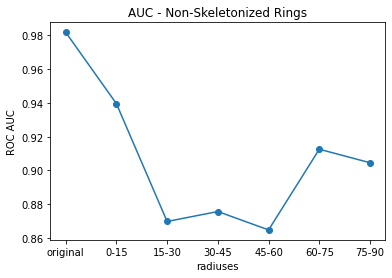

In [48]:
plt.scatter(radiuses_15,auc_non_skel_15_center_preserved)
plt.plot(radiuses_15, auc_non_skel_15_center_preserved)
plt.xlabel('radiuses')
plt.ylabel('ROC AUC')
plt.title('AUC - Non-Skeletonized Rings')

plt.show()

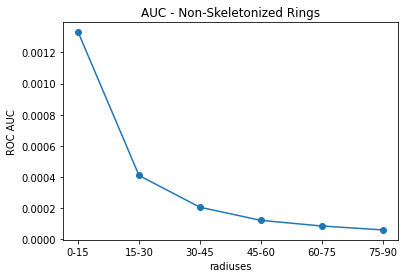

In [65]:
plt.scatter(radiuses_15[1:], test_arr)
plt.plot(radiuses_15[1:], test_arr)
plt.xlabel('radiuses')
plt.ylabel('ROC AUC')
plt.title('AUC - Non-Skeletonized Rings')

plt.show()

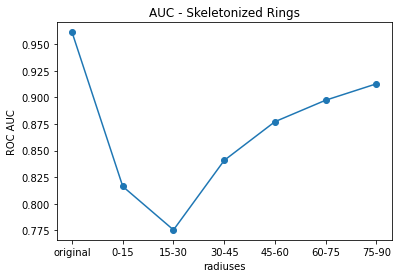

In [12]:
plt.scatter(radiuses_15,auc_skel_15_center_preserved)
plt.plot(radiuses_15, auc_skel_15_center_preserved)
plt.xlabel('radiuses')
plt.ylabel('ROC AUC')
plt.title('AUC - Skeletonized Rings')

plt.show()

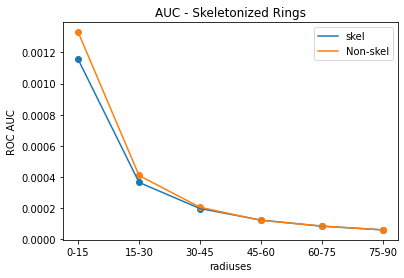

In [72]:
plt.scatter(radiuses_15[1:],test_arr_skel)
plt.plot(radiuses_15[1:], test_arr_skel, label = 'skel')

plt.scatter(radiuses_15[1:], test_arr)
plt.plot(radiuses_15[1:], test_arr, label = 'Non-skel')

plt.xlabel('radiuses')
plt.ylabel('ROC AUC')
plt.title('AUC - Skeletonized Rings')

plt.legend()

plt.show()

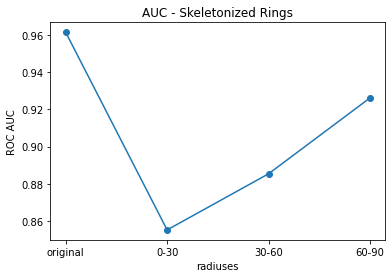

In [15]:
plt.scatter(radiuses_30,auc_skel_30_center_preserved)
plt.plot(radiuses_30, auc_skel_30_center_preserved)
plt.xlabel('radiuses')
plt.ylabel('ROC AUC')
plt.title('AUC - Skeletonized Rings')

plt.show()